# Task 2 - Medical Report Generation with MedGemma (PneumoniaMNIST)

<!-- <img src="https://drive.google.com/uc?export=view&id=1oqQCD3-l-wRtJC1WZ-CgB9SCweEtF1ig" width="400" height="500" alt="task2" align="right" border="1" hspace="0" vspace="0"> -->


## Cell A - Mount Google Drive + Create Output Directories
This cell mounts Google Drive into the Colab filesystem and creates a stable directory structure for all outputs. Colab runtimes are non-persistent , so Drive mounting is the simplest way to reports, figures, saved models, etc.

- Mounts Drive at `/content/drive`.
- Sets `DRIVE_BASE` to a task-specific folder.
- Creates subdirectories for `outputs/`, `outputs/reports/`, and `outputs/figures/`.

### Reproducibility note
Outside Colab, replace Drive mounting with a local `outputs/` folder but keep the same directory structure to avoid changing downstream code.

In [1]:
# ============================================================================
# Cell A: Mount Google Drive + Create Output Directories
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

import os
DRIVE_BASE = "/content/drive/MyDrive/postdoc_challenge/task2"
os.makedirs(f"{DRIVE_BASE}/reports", exist_ok=True)
os.makedirs(f"{DRIVE_BASE}/images", exist_ok=True)
os.makedirs(f"{DRIVE_BASE}/results", exist_ok=True)

print(f"Drive mounted. Outputs will be saved to: {DRIVE_BASE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted. Outputs will be saved to: /content/drive/MyDrive/postdoc_challenge/task2


In [2]:
# ============================================================================
# Cell B: Install Dependencies
# ============================================================================

# installed once only in the current session

!pip install -U transformers accelerate medmnist pillow pandas matplotlib scikit-learn

## Cell C - Hugging Face Authentication
Authenticates the Colab session using a token stored in Colab's secure `Secrets` code.

- Reads `HF_TOKEN` from Colab secure storage.
- Calls `huggingface_hub.login(...)` to enable authenticated downloads and caching.


In [3]:
# ============================================================================
# Cell C: HuggingFace Authentication
# ============================================================================

from google.colab import userdata
from huggingface_hub import login
login(token=userdata.get("HF_TOKEN"))
print("Authenticated with HuggingFace.")

Authenticated with HuggingFace.


## Cell 1 - Imports and Setup
VLM inference is resource-intensive, it's important to confirm PyTorch/CUDA availability.

- Imports core utilities.
- Imports PyTorch modules used both for CNN loading (optional) and for VLM
- Prints PyTorch version, CUDA availability, and GPU properties

In [4]:
# ============================================================================
# Cell 1: Imports and Setup
# ============================================================================

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: Tesla T4
VRAM: 14.56 GB


## Cell 2 - Configuration (Hyperparameters and Paths)

### Key configuration groups
- **VLM:** model ID, `max_new_tokens`, `temperature`, and sampling mode.
- **Image preprocessing:** upscale target (28x28 -> 224x224).
- **Sampling plan:** number of Normal vs Pneumonia examples and ambiguous cases (with low confidence)
- **Baseline:** optional Task 1 CNN checkpoint path (saved from task1)


In [5]:
# ============================================================================
# Cell 2: Configuration
# ============================================================================

CONFIG = {
    # MedGemma
    "vlm_model_id": "google/medgemma-1.5-4b-it",
    "vlm_max_new_tokens": 512,
    "vlm_temperature": 0.3,       # Low for clinical consistency
    "vlm_do_sample": True,

    # Image preprocessing
    "upscale_size": 224,           # 28x28 -> 224x224 for VLM input

    # Sample selection
    "n_normal": 5,                 # Normal cases to select
    "n_pneumonia": 5,              # Pneumonia cases to select
    "n_ambiguous": 2,              # Near-boundary cases (extra, CNN only)
    "random_seed": 42,

    # Optional: CNN model from Task 1 (on Drive)
    "cnn_model_path": "/content/drive/MyDrive/postdoc_challenge/task1/task1_best_model.pth",

    # # Output paths
    # "output_dir": "task2_outputs",
    # "report_dir": "task2_outputs/reports",
    # "figure_dir": "task2_outputs/figures",

    # Output paths (on Drive — survives session reset)
    "report_dir":  f"{DRIVE_BASE}/reports",
    "figure_dir":  f"{DRIVE_BASE}/images",
    "results_dir": f"{DRIVE_BASE}/results",
}

for d in [CONFIG["results_dir"], CONFIG["report_dir"], CONFIG["figure_dir"]]:
    os.makedirs(d, exist_ok=True)

## Cell 3 - Load PneumoniaMNIST (MedMNIST) Test Split

- Imports `PneumoniaMNIST`
- Loads the **test** split (`download=True`, `size=28`).
- Extracts all labels into a NumPy array, handling both scalar tensors and Python ints.
- Prints the class balance.

### Observed dataset summary (from the stored notebook output)
- Test images: 624
- Normal: 234 (37.5%)
- Pneumonia: 390 (62.5%)

### Limitations
PneumoniaMNIST images are `28x28` pixels. This is far below clinical resolution.


In [6]:
# ============================================================================
# Cell 3: Load PneumoniaMNIST Dataset
# ============================================================================

import medmnist
from medmnist import PneumoniaMNIST

print(f"MedMNIST version: {medmnist.__version__}")

# Load test set without transforms (raw PIL images for VLM)
test_dataset = PneumoniaMNIST(split="test", download=True, size=28)

# Extract all labels
test_labels = np.array([int(test_dataset[i][1].item()
                         if hasattr(test_dataset[i][1], "item")
                         else int(test_dataset[i][1]))
                        for i in range(len(test_dataset))])

n_normal = np.sum(test_labels == 0)
n_pneumonia = np.sum(test_labels == 1)
print(f"Test set: {len(test_dataset)} images")
print(f"  Normal (0):    {n_normal} ({100*n_normal/len(test_dataset):.1f}%)")
print(f"  Pneumonia (1): {n_pneumonia} ({100*n_pneumonia/len(test_dataset):.1f}%)")

MedMNIST version: 3.0.2
Test set: 624 images
  Normal (0):    234 (37.5%)
  Pneumonia (1): 390 (62.5%)


## Cell 4 - Load Task 1 CNN for Discriminative Baseline Comparison
This cell optionally loads a CNN trained in Task 1 (notebook provided with this repo) and runs inference across the PneumoniaMNIST test set. The CNN provides a baseline (single probability), enabling comparison against the VLM's text-based assessment.

### Model architecture (must match the checkpoint)
- Convolution + BatchNorm + ReLU blocks; pooling in early layers.
- Global pooling (`AdaptiveAvgPool2d`) + dropout + linear layer producing a single logit.
- Sigmoid converts the logit to a probability; threshold 0.5 yields the hard class.

### Inference protocol
- Uses `torchvision.transforms` to normalize the grayscale input (`mean=0.5`, `std=0.5`).

### Observed baseline performance (from stored output)
- Loaded checkpoint parameters: 93,025
- Reported test accuracy: 0.93


In [7]:
# ============================================================================
# Cell 4: (Optional) Load Task 1 CNN for Comparison
# ============================================================================
# If you have the CNN model from Task 1, set CONFIG["cnn_model_path"].
# The script works fully without it -- CNN columns simply won't appear.

CNN_AVAILABLE = False
cnn_preds = None
cnn_probs = None

if CONFIG["cnn_model_path"] and os.path.exists(CONFIG["cnn_model_path"]):
    print(f"Loading CNN model from: {CONFIG['cnn_model_path']}")

    # --- Task 1 architecture (MUST exactly match saved weights) ---
    # Copied verbatim from Task 1 PneumoniaCNN to guarantee state_dict key match.
    class PneumoniaCNN(nn.Module):
        def __init__(self, dropout_rate=0.3):
            super().__init__()
            self.features = nn.Sequential(
                # Block 1
                nn.Conv2d(1, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout2d(0.10),
                # Block 2
                nn.Conv2d(32, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout2d(0.15),
                # Block 3
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout2d(0.20),
            )
            self.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(128, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(128, 1),
            )
        def forward(self, x):
            x = self.features(x)
            x = self.head(x)
            return x.squeeze(1)  # logits

    from torchvision import transforms

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_model = PneumoniaCNN(dropout_rate=0.3)
    checkpoint = torch.load(CONFIG["cnn_model_path"], map_location=device, weights_only=False)
    # Handle different checkpoint formats (incl. Task 1 key 'model_state_dict')
    if isinstance(checkpoint, dict):
        state_dict = checkpoint.get("model_state_dict",
                     checkpoint.get("model_state",
                     checkpoint.get("state_dict", checkpoint)))
    else:
        state_dict = checkpoint
    cnn_model.load_state_dict(state_dict)
    cnn_model.eval().to(device)
    print(f"CNN loaded: {sum(p.numel() for p in cnn_model.parameters()):,} params")

    # Run inference on test set
    # Normalization MUST match Task 1 (dataset-computed mean/std, NOT generic 0.5/0.5)
    CNN_MEAN, CNN_STD = 0.5719, 0.1684  # from Task 1 training set
    cnn_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[CNN_MEAN], std=[CNN_STD]),
    ])
    test_cnn = PneumoniaMNIST(split="test", download=True, size=28, transform=cnn_transform)

    cnn_probs_list, cnn_preds_list = [], []
    with torch.no_grad():
        for i in range(len(test_cnn)):
            img, _ = test_cnn[i]
            if img.ndim == 2:
                img = img.unsqueeze(0)
            img = img.unsqueeze(0).to(device)
            logit = cnn_model(img)
            prob = torch.sigmoid(logit).item()
            cnn_probs_list.append(prob)
            cnn_preds_list.append(1 if prob > 0.5 else 0)

    cnn_probs = np.array(cnn_probs_list)
    cnn_preds = np.array(cnn_preds_list)
    CNN_AVAILABLE = True

    from sklearn.metrics import accuracy_score
    print(f"CNN Test Accuracy: {accuracy_score(test_labels, cnn_preds):.4f}")
else:
    print("No CNN model provided -- running Task 2 without Task 1 comparison.")
    print("Set CONFIG['cnn_model_path'] = 'task1_custom_cnn_pneumonia_model.pth' to enable.")


Loading CNN model from: /content/drive/MyDrive/postdoc_challenge/task1/task1_best_model.pth
CNN loaded: 304,225 params
CNN Test Accuracy: 0.9375


## Cell 5 - Representative Image Selection for Qualitative Analysis
Generating detailed reports for all 624 images is expensive and hard to audit. This cell selects a small, diverse subset that is informative for qualitative review and error analysis.

### Sampling strategy
- **With CNN available:** stratify by outcome type (TP/TN/FP/FN) to include both successes and failures.
- **Ambiguous set:** optionally add low-confidence CNN cases (probability closest to 0.5) to probe decision boundaries.
- **Without CNN:** fall back to random stratified sampling within each ground-truth class.

### Why?
- Misclassified cases often reveal systematic failure modes (label noise, artifacts, domain mismatch).
- Near-boundary cases test whether the VLM expresses uncertainty appropriately.

### Note
The stored output shows 12 selected images (including multiple ambiguous low-confidence cases).


In [8]:
# ============================================================================
# Cell 5: Select Representative Images
# ============================================================================

def select_representative_images(test_labels, cnn_preds=None, cnn_probs=None,
                                  n_normal=5, n_pneumonia=5, n_ambiguous=2,
                                  seed=42):

    rng = np.random.RandomState(seed)
    selected = []

    normal_idx = np.where(test_labels == 0)[0]
    pneumonia_idx = np.where(test_labels == 1)[0]

    def _pick(indices, n):
        if len(indices) == 0:
            return []
        return rng.choice(indices, size=min(n, len(indices)), replace=False).tolist()

    if cnn_preds is not None:
        # --- CNN available: stratify by prediction outcome ---
        normal_fp = normal_idx[cnn_preds[normal_idx] == 1]
        normal_tn = normal_idx[cnn_preds[normal_idx] == 0]
        pneum_fn  = pneumonia_idx[cnn_preds[pneumonia_idx] == 0]
        pneum_tp  = pneumonia_idx[cnn_preds[pneumonia_idx] == 1]

        # Mix: include some misclassified + some correctly classified
        n_fp = min(2, len(normal_fp))
        n_fn = min(2, len(pneum_fn))
        chosen_normal = _pick(normal_fp, n_fp) + _pick(normal_tn, n_normal - n_fp)
        chosen_pneum  = _pick(pneum_fn, n_fn) + _pick(pneum_tp, n_pneumonia - n_fn)

        for idx in chosen_normal:
            conf = (1.0 - cnn_probs[idx]) if cnn_preds[idx] == 0 else cnn_probs[idx]
            selected.append({
                "index": int(idx),
                "ground_truth": 0, "gt_label": "Normal",
                "cnn_prediction": int(cnn_preds[idx]),
                "cnn_label": "Pneumonia" if cnn_preds[idx] == 1 else "Normal",
                "cnn_confidence": float(conf),
                "category": "False Positive" if cnn_preds[idx] == 1 else "True Negative",
            })
        for idx in chosen_pneum:
            conf = cnn_probs[idx] if cnn_preds[idx] == 1 else (1.0 - cnn_probs[idx])
            selected.append({
                "index": int(idx),
                "ground_truth": 1, "gt_label": "Pneumonia",
                "cnn_prediction": int(cnn_preds[idx]),
                "cnn_label": "Pneumonia" if cnn_preds[idx] == 1 else "Normal",
                "cnn_confidence": float(conf),
                "category": "True Positive" if cnn_preds[idx] == 1 else "False Negative",
            })

        # Ambiguous: most uncertain CNN predictions
        if n_ambiguous > 0:
            already = {s["index"] for s in selected}
            uncertainty = np.abs(cnn_probs - 0.5)
            for idx in np.argsort(uncertainty):
                if int(idx) not in already:
                    conf = cnn_probs[idx] if cnn_preds[idx] == 1 else (1.0 - cnn_probs[idx])
                    selected.append({
                        "index": int(idx),
                        "ground_truth": int(test_labels[idx]),
                        "gt_label": "Pneumonia" if test_labels[idx] == 1 else "Normal",
                        "cnn_prediction": int(cnn_preds[idx]),
                        "cnn_label": "Pneumonia" if cnn_preds[idx] == 1 else "Normal",
                        "cnn_confidence": float(conf),
                        "category": "Ambiguous (Low CNN Confidence)",
                    })
                    already.add(int(idx))
                    if len(selected) >= n_normal + n_pneumonia + n_ambiguous:
                        break
    else:
        # --- No CNN: random stratified selection ---
        chosen_normal = _pick(normal_idx, n_normal)
        chosen_pneum  = _pick(pneumonia_idx, n_pneumonia)

        for idx in chosen_normal:
            selected.append({
                "index": int(idx),
                "ground_truth": 0, "gt_label": "Normal",
                "cnn_prediction": None, "cnn_label": None,
                "cnn_confidence": None,
                "category": "Normal (Random Sample)",
            })
        for idx in chosen_pneum:
            selected.append({
                "index": int(idx),
                "ground_truth": 1, "gt_label": "Pneumonia",
                "cnn_prediction": None, "cnn_label": None,
                "cnn_confidence": None,
                "category": "Pneumonia (Random Sample)",
            })

    # Print selection summary
    print(f"\nSelected {len(selected)} images:")
    for s in selected:
        cnn_str = ""
        if s["cnn_label"]:
            cnn_str = f" | CNN: {s['cnn_label']} ({s['cnn_confidence']:.3f})"
        print(f"  #{s['index']:3d}  GT: {s['gt_label']:<10s}{cnn_str}  [{s['category']}]")
    return selected


selected_images = select_representative_images(
    test_labels, cnn_preds, cnn_probs,
    n_normal=CONFIG["n_normal"],
    n_pneumonia=CONFIG["n_pneumonia"],
    n_ambiguous=CONFIG["n_ambiguous"] if CNN_AVAILABLE else 0,
    seed=CONFIG["random_seed"],
)



Selected 12 images:
  #146  GT: Normal     | CNN: Pneumonia (0.657)  [False Positive]
  #370  GT: Normal     | CNN: Pneumonia (0.999)  [False Positive]
  # 68  GT: Normal     | CNN: Normal (0.959)  [True Negative]
  # 30  GT: Normal     | CNN: Normal (0.717)  [True Negative]
  #267  GT: Normal     | CNN: Normal (0.993)  [True Negative]
  #176  GT: Pneumonia  | CNN: Normal (0.979)  [False Negative]
  #608  GT: Pneumonia  | CNN: Normal (0.668)  [False Negative]
  #406  GT: Pneumonia  | CNN: Pneumonia (1.000)  [True Positive]
  #409  GT: Pneumonia  | CNN: Pneumonia (1.000)  [True Positive]
  #359  GT: Pneumonia  | CNN: Pneumonia (1.000)  [True Positive]
  #180  GT: Pneumonia  | CNN: Normal (0.513)  [Ambiguous (Low CNN Confidence)]
  #423  GT: Normal     | CNN: Normal (0.518)  [Ambiguous (Low CNN Confidence)]


In [9]:
from IPython.display import display, HTML

def render_report_clean(image_id, report_text, cnn_pred=None, gt_label=None):

    html_template = f"""
    <div style='font-family: Georgia, serif; background-color: #ffffff;
                border: 1px solid #d0d0d0; padding: 25px; margin-bottom: 25px;
                max-width: 800px; line-height: 1.6;'>
        <h2 style='text-align: center; font-weight: bold;'>Radiology Report</h2>
        <hr>
        <p><strong>Image ID:</strong> {image_id}</p>
        <p><strong>Ground Truth:</strong> {gt_label}</p>
        <p><strong>CNN Prediction:</strong> {cnn_pred}</p>
        <hr>
        <div style='white-space: pre-wrap; font-size: 15px;'>
            {report_text}
        </div>
    </div>
    """
    display(HTML(html_template))

## Cell 6 - Image Preprocessing for VLM Compatibility (Upscale + RGB)
MedGemma expects a 3-channel RGB image at a reasonable spatial size. PneumoniaMNIST is `28x28` grayscale. This cell:

1. Convert raw data to an 8-bit grayscale image.
2. Upscale to `224x224` (bicubic).
3. Convert grayscale -> RGB.

### Scientific caveat
Upscaling does not recover information; it only changes the sampling grid. Therefore, detailed anatomical claims in generated text should be treated as suspect and explicitly audited.

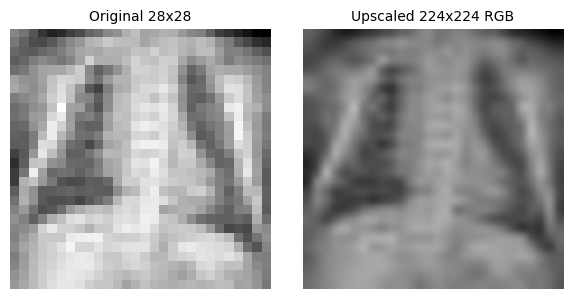

Image preprocessing verified.


In [10]:
# ============================================================================
# Cell 6: Image Preprocessing for VLM
# ============================================================================

def prepare_image_for_vlm(dataset, index, upscale_size=224):
    img, _ = dataset[index]

    if isinstance(img, torch.Tensor):
        img_array = img.numpy()
    elif isinstance(img, Image.Image):
        img_array = np.array(img)
    else:
        img_array = np.array(img)

    if img_array.ndim == 3:
        img_array = img_array.squeeze()

    if img_array.dtype != np.uint8:
        if img_array.max() <= 1.0:
            img_array = (img_array * 255).astype(np.uint8)
        else:
            img_array = img_array.astype(np.uint8)

    pil_orig = Image.fromarray(img_array, mode="L")
    pil_upscaled = pil_orig.resize((upscale_size, upscale_size), resample=Image.BICUBIC)
    pil_rgb = pil_upscaled.convert("RGB")

    return pil_rgb, pil_orig


# Quick visual verification
sample_rgb, sample_orig = prepare_image_for_vlm(test_dataset, (selected_images[0]['index'] if 'selected_images' in globals() else 0))
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(np.array(sample_orig), cmap="gray")
axes[0].set_title("Original 28x28", fontsize=10)
axes[1].imshow(np.array(sample_rgb))
axes[1].set_title(f"Upscaled {CONFIG['upscale_size']}x{CONFIG['upscale_size']} RGB", fontsize=10)
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.savefig(f"{CONFIG['figure_dir']}/preprocessing_example.png", dpi=300, bbox_inches="tight")
plt.show()
print("Image preprocessing verified.")

## Cell 7 - Load MedGemma 1.5 4B-IT (Vision-Language Model)
This cell loads the VLM used throughout Task 2 via Hugging Face Transformers (`AutoModelForImageTextToText` + `AutoProcessor`).

### Key implementation choices
- `torch_dtype=bfloat16`: reduces memory while preserving stability on modern GPUs.
- `device_map="auto"`: lets Transformers place weights on available devices.

### Operational notes
- First run downloads large weights; subsequent runs use the local cache.
- Access may require accepting model terms on hugging face
- T4 GPU (Runtime > Change runtime type > T4 GPU)
- HuggingFace auth with gated model access (Cell 1)
- License accepted: https://huggingface.co/google/medgemma-1.5-4b-it


In [11]:
# ============================================================================
# Cell 7: Load MedGemma 1.5 4B-IT
# ============================================================================

from transformers import AutoProcessor, AutoModelForImageTextToText

MODEL_ID = CONFIG["vlm_model_id"]

print(f"Loading model: {MODEL_ID}")
print("First run downloads ~8GB of weights; subsequent runs use cache.")

vlm_model = AutoModelForImageTextToText.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
vlm_processor = AutoProcessor.from_pretrained(MODEL_ID)

print(f"Model loaded successfully.")
print(f"Device: {vlm_model.device}")

Loading model: google/medgemma-1.5-4b-it
First run downloads ~8GB of weights; subsequent runs use cache.


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

The image processor of type `Gemma3ImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Model loaded successfully.
Device: cuda:0


## Cell 8 - Prompting Strategies (Experimental Conditions)
Prompting is the main independent variable in this notebook. We define three strategies that trade off freedom, structure, and evaluability.

### Strategies
- **Baseline:** minimal instruction to characterize default behavior (experimental control).
- **Structured clinical report:** requests FINDINGS / IMPRESSION / CLASSIFICATION sections.
- **Constrained binary assessment:** forces a Yes/No pneumonia decision, supporting cues, and confidence level.

### Why multiple prompts?
- Structured prompts often improve consistency and make outputs easier to audit.
- Constrained prompts enable  quantitative comparisons (text -> label extraction).
- Comparing prompts can reveal which conditions elicit more hallucination-prone language.


In [12]:
# ============================================================================
# Cell 8: Define Prompting Strategies
# ============================================================================

PROMPTS = {
    "baseline": {
        "name": "Baseline (Open-ended)",
        "text": (
            "Describe this chest X-ray image. "
            "What findings do you observe?"
        ),
        "rationale": (
            "Open-ended prompt with no structural constraints. "
            "Establishes what the model generates with minimal guidance. "
            "Serves as the experimental control."
        ),
    },
    "structured_clinical": {
        "name": "Structured Clinical Report",
        "text": (
            "You are a radiologist reviewing a chest X-ray. "
            "Provide a structured report with the following sections:\n"
            "1. FINDINGS: Describe all observable features of the chest X-ray.\n"
            "2. IMPRESSION: Summarize the overall assessment.\n"
            "3. CLASSIFICATION: State whether the X-ray appears Normal or "
            "shows signs of Pneumonia.\n"
            "Be concise and clinically precise."
        ),
        "rationale": (
            "Structured prompt mimicking radiology reporting format. "
            "Tests whether explicit structure improves clinical relevance "
            "and output organization. Role assignment ('radiologist') may "
            "activate domain-specific language patterns."
        ),
    },
    "constrained_binary": {
        "name": "Constrained Binary Assessment",
        "text": (
            "Examine this chest X-ray image carefully. "
            "Based on what you observe, answer the following:\n"
            "1. Is there evidence of pneumonia in this image? (Yes/No)\n"
            "2. What specific visual features support your assessment?\n"
            "3. How confident are you in this assessment? (High/Medium/Low)\n"
            "You must answer Yes or No for question 1 even if image quality is limited."
        ),
        "rationale": (
            "Forces binary classification output, directly comparable to "
            "ground truth labels and CNN predictions. Final instruction ensures "
            "classification is provided even on degraded inputs, while confidence "
            "level (Q3) captures self-calibration without allowing refusal."
        ),
    },
}

print("Prompting Strategies Defined:")
for key, p in PROMPTS.items():
    print(f"\n  [{key}] {p['name']}")
    print(f"  Rationale: {p['rationale'][:80]}...")

Prompting Strategies Defined:

  [baseline] Baseline (Open-ended)
  Rationale: Open-ended prompt with no structural constraints. Establishes what the model gen...

  [structured_clinical] Structured Clinical Report
  Rationale: Structured prompt mimicking radiology reporting format. Tests whether explicit s...

  [constrained_binary] Constrained Binary Assessment
  Rationale: Forces binary classification output, directly comparable to ground truth labels ...


## Cell 9 - Report Generation Function (Image + Prompt -> Text)
Given an RGB PIL image and a prompt string, this cell runs MedGemma to produce a report.

### Mechanics
- Packages the input as a chat message containing an image block and a text block.
- Uses `apply_chat_template(..., add_generation_prompt=True)` to match the model's expected conversation framing.
- Moves tensors to the model device and uses `torch.inference_mode()` for efficient inference.
- Samples when `temperature > 0`, otherwise uses greedy decoding.
- Decodes only the newly generated tokens to avoid echoing the prompt.


In [13]:
# ============================================================================
# Cell 9: Report Generation Function
# ============================================================================

def generate_report(image, prompt_text, vlm_model, vlm_processor,
                    max_new_tokens=512, temperature=0.3):

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt_text},
            ],
        }
    ]

    # Tokenize and process image
    inputs = vlm_processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(vlm_model.device, dtype=torch.bfloat16)

    input_len = inputs["input_ids"].shape[-1]

    # Generate
    with torch.inference_mode():
        if temperature > 0:
            output_ids = vlm_model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
            )
        else:
            output_ids = vlm_model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
            )

    # Decode only the generated portion
    generated_ids = output_ids[0][input_len:]
    return vlm_processor.decode(generated_ids, skip_special_tokens=True)

## Cell 10 - Batch Generation: All Selected Images x All Prompts
This cell executes the main experiment: for each curated image, generate one report per prompt strategy. The result is stored as a clean table (`df_results`) and exported to CSV for analysis.

### What the code does
- Preprocesses each selected image (`28x28` -> `224x224` RGB).
- Iterates over prompt strategies and calls `generate_report`.
- Stores metadata for each run: image index, category, ground truth, optional CNN prediction/confidence, prompt name/key, and generated report text.
- Saves `vlm_reports.csv` to the output directory.

### Runtime expectations
On Google Colab T4 GPU -> 9 to 15 mins

In [14]:
# ============================================================================
# Cell 10: Generate All Reports
# ============================================================================

def run_all_reports(selected_images, test_dataset, prompts,
                    vlm_model, vlm_processor, config):
    results = []
    total = len(selected_images) if 'selected_images' in globals() else 0 * len(prompts)
    count = 0

    for img_info in selected_images:
        idx = img_info["index"]
        pil_rgb, _ = prepare_image_for_vlm(test_dataset, idx, config["upscale_size"])

        for prompt_key, prompt_data in prompts.items():
            count += 1
            label = f"[{count:2d}/{total}] #{idx:3d} | {prompt_data['name'][:30]:<30s}"
            print(label, end="", flush=True)

            try:
                report = generate_report(
                    image=pil_rgb,
                    prompt_text=prompt_data["text"],
                    vlm_model=vlm_model,
                    vlm_processor=vlm_processor,
                    max_new_tokens=config["vlm_max_new_tokens"],
                    temperature=config["vlm_temperature"],
                )
                print(f" -> {len(report)} chars")
            except Exception as e:
                report = f"[GENERATION FAILED: {str(e)}]"
                print(f" -> ERROR: {e}")

            results.append({
                "image_index": idx,
                "category": img_info["category"],
                "ground_truth": img_info["gt_label"],
                "cnn_prediction": img_info.get("cnn_label"),
                "cnn_confidence": img_info.get("cnn_confidence"),
                "prompt_strategy": prompt_data["name"],
                "prompt_key": prompt_key,
                "generated_report": report,
            })

    return results


n_images = len(selected_images)
n_prompts = len(PROMPTS)
print(f"Generating reports: {n_images} images x {n_prompts} prompts = {n_images * n_prompts} total")
print(f"Estimated time: ~{n_images * n_prompts * 15 // 60}--{n_images * n_prompts * 25 // 60} min on T4")
print("=" * 65)

results = run_all_reports(selected_images, test_dataset, PROMPTS,
                          vlm_model, vlm_processor, CONFIG)

df_results = pd.DataFrame(results)
df_results.to_csv(f"{CONFIG['results_dir']}/vlm_reports.csv", index=False)
print(f"\nAll {len(results)} reports saved to {CONFIG['results_dir']}/vlm_reports.csv")

Generating reports: 12 images x 3 prompts = 36 total
Estimated time: ~9--15 min on T4
[ 1/12] #146 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1558 chars
[ 2/12] #146 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 317 chars
[ 3/12] #146 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 313 chars
[ 4/12] #370 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1334 chars
[ 5/12] #370 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 333 chars
[ 6/12] #370 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 317 chars
[ 7/12] # 68 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1622 chars
[ 8/12] # 68 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 347 chars
[ 9/12] # 68 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 186 chars
[10/12] # 30 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1478 chars
[11/12] # 30 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 252 chars
[12/12] # 30 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 481 chars
[13/12] #267 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1262 chars
[14/12] #267 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 327 chars
[15/12] #267 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 424 chars
[16/12] #176 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1205 chars
[17/12] #176 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 286 chars
[18/12] #176 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 172 chars
[19/12] #608 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1654 chars
[20/12] #608 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 263 chars
[21/12] #608 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 185 chars
[22/12] #406 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 918 chars
[23/12] #406 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 311 chars
[24/12] #406 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 221 chars
[25/12] #409 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1754 chars
[26/12] #409 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 253 chars
[27/12] #409 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 212 chars
[28/12] #359 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1461 chars
[29/12] #359 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 251 chars
[30/12] #359 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 207 chars
[31/12] #180 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1281 chars
[32/12] #180 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 320 chars
[33/12] #180 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 185 chars
[34/12] #423 | Baseline (Open-ended)         

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 1139 chars
[35/12] #423 | Structured Clinical Report    

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 287 chars
[36/12] #423 | Constrained Binary Assessment 

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


 -> 194 chars

All 36 reports saved to /content/drive/MyDrive/postdoc_challenge/task2/results/vlm_reports.csv


## Cell 11 - Qualitative Visualization
- The input image
- Ground truth and CNN metadata
- One VLM report per prompt strategy

### What the code does
- Defines a helper to draw rounded rectangles using Matplotlib patches.
- Assembles a multi-column panel per image (`visualize_image_reports`).
- Generates panels for one example per category to keep notebook output manageable.

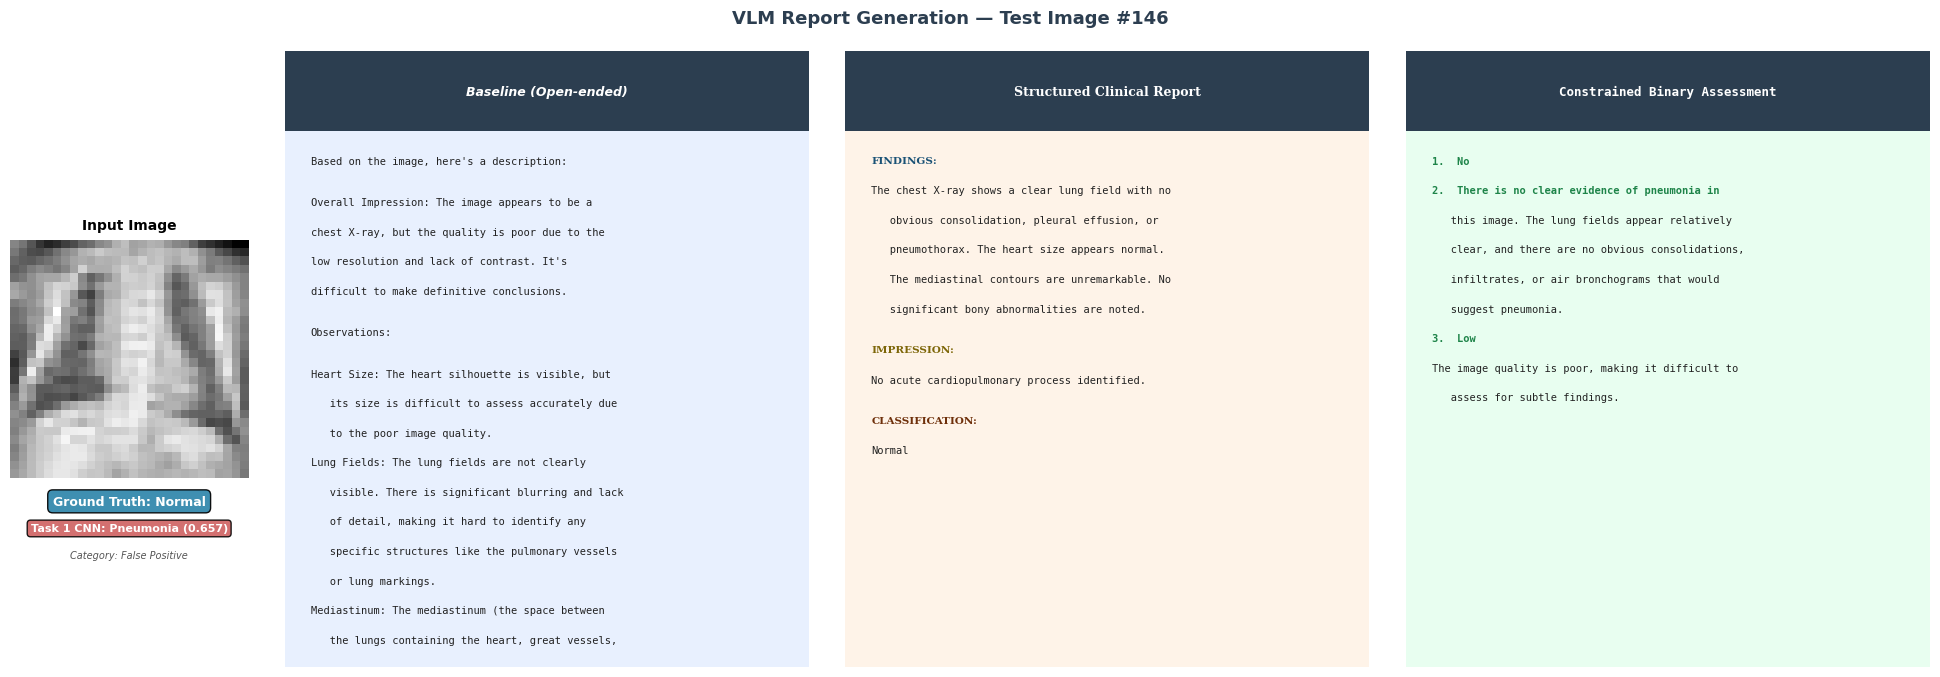

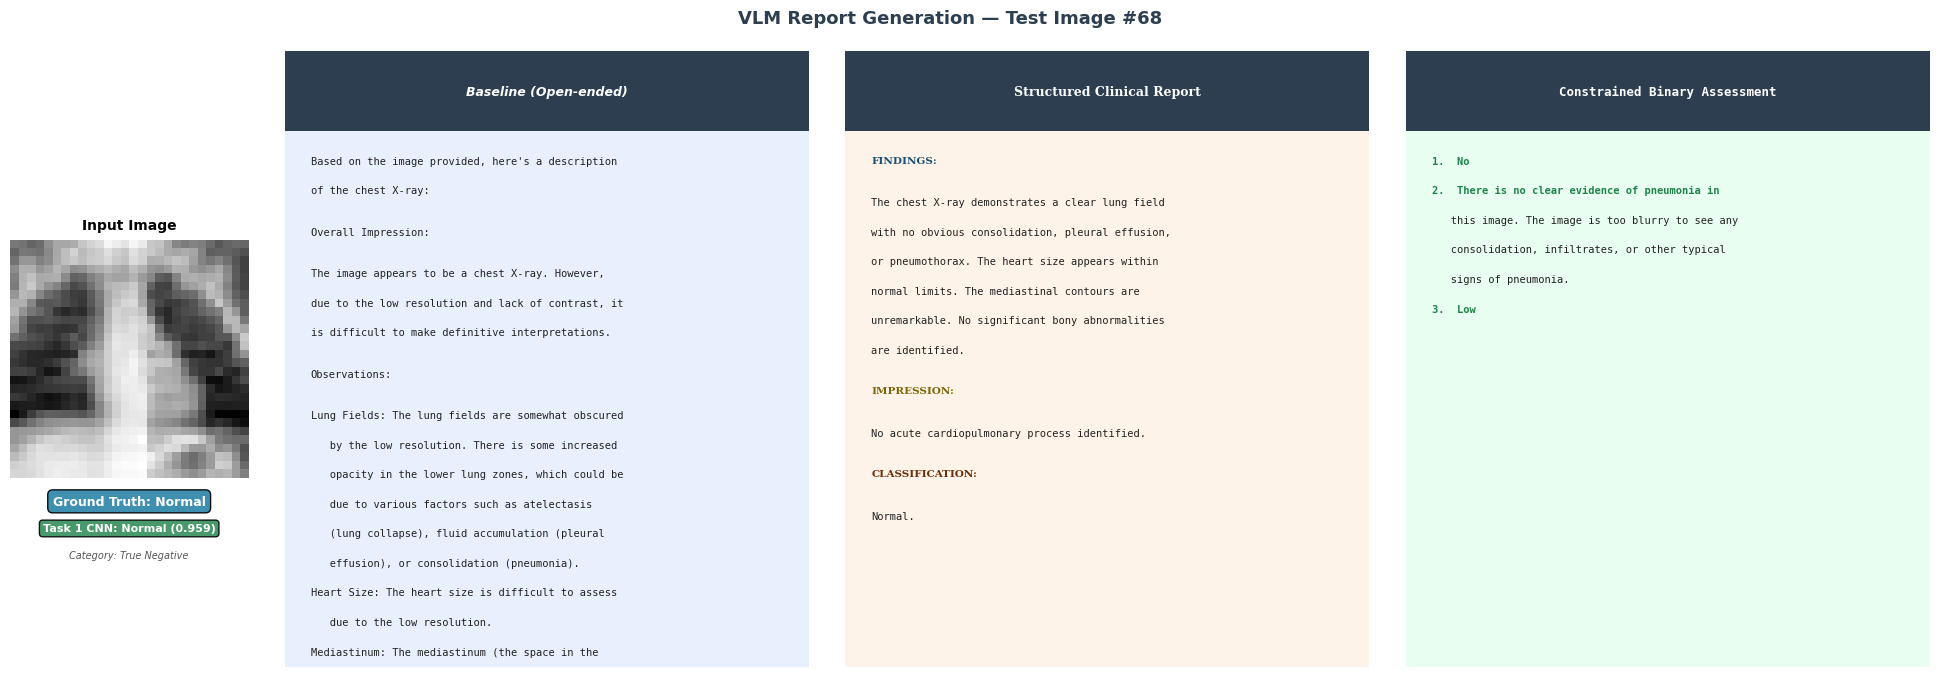

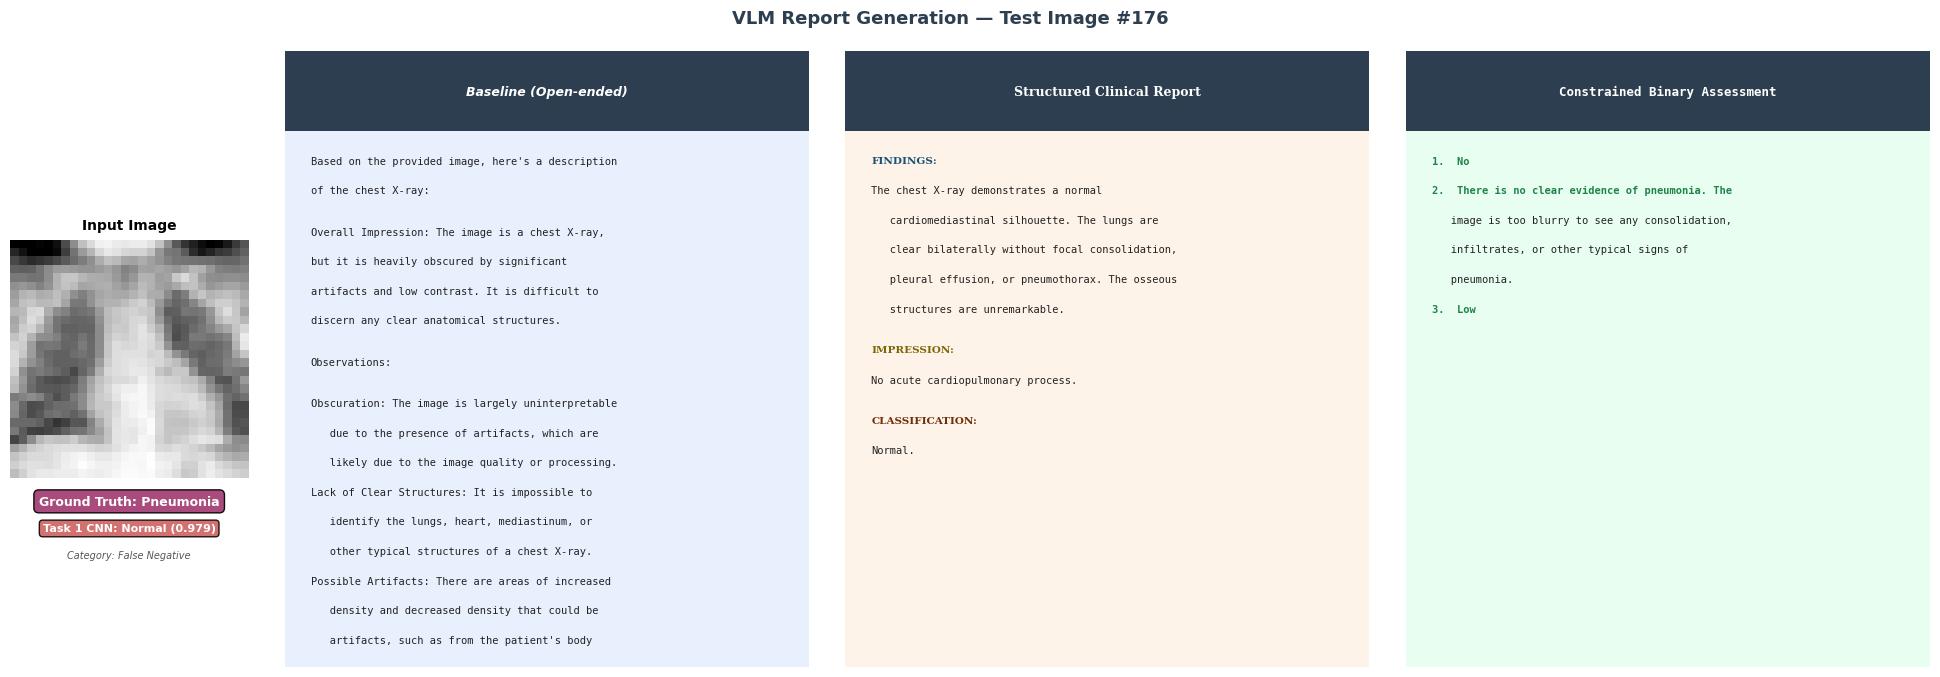

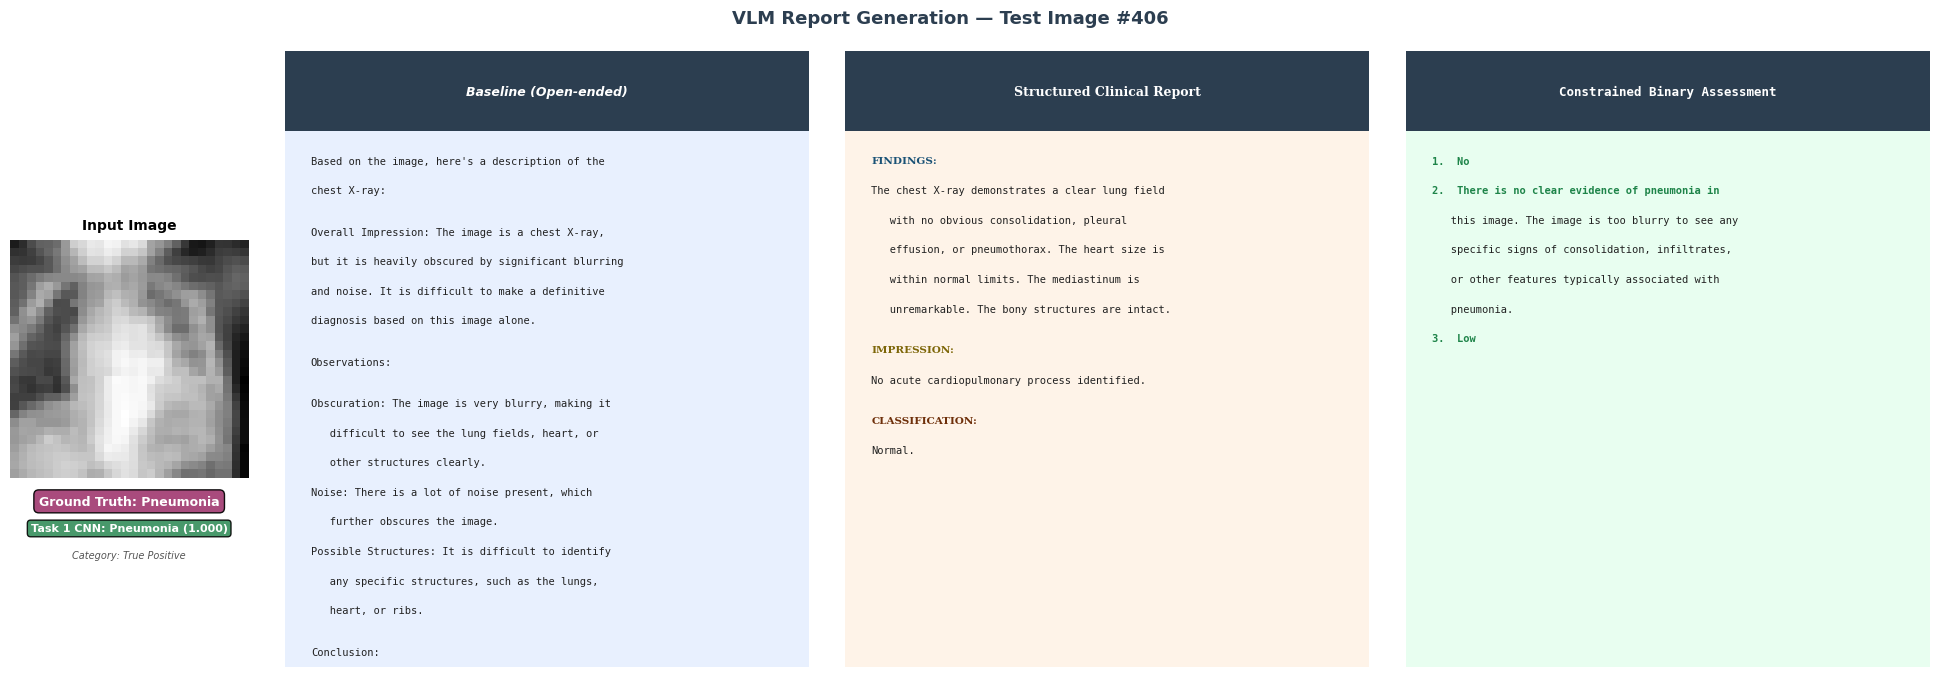

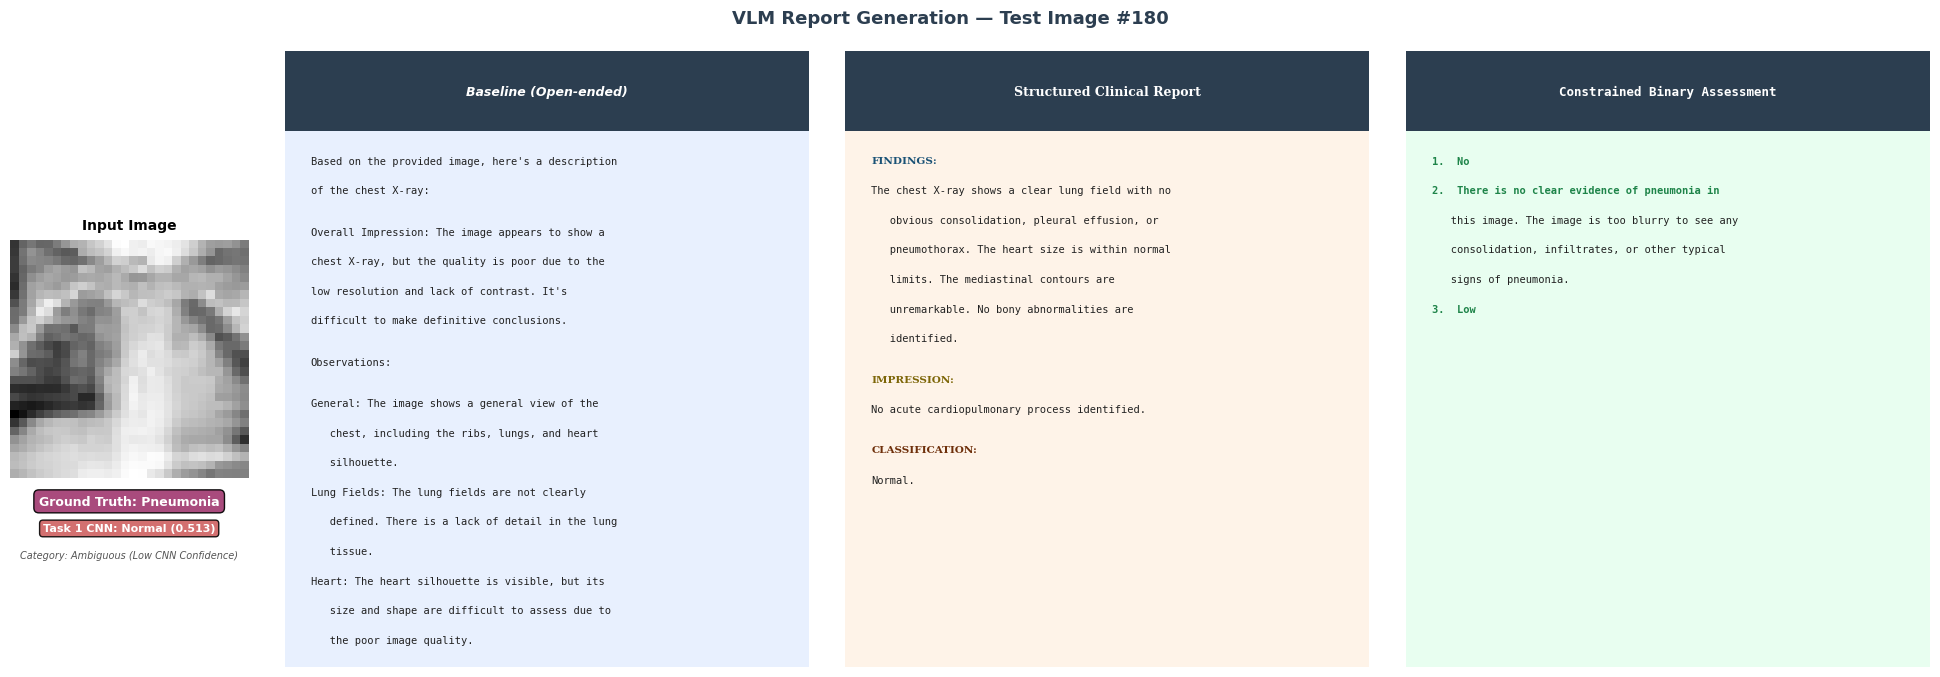

In [15]:
# ============================================================================
# Cell 11: Visualize Reports (Academic Figure Style) — FIXED
# ============================================================================

import re
import textwrap

# --- Color palette (consistent across all figures) ---
COLORS = {
    "gt_normal":    "#2E86AB",
    "gt_pneumonia": "#A23B72",
    "cnn_correct":  "#2E8B57",
    "cnn_wrong":    "#CD5C5C",
    "vlm_correct":  "#2E8B57",
    "vlm_wrong":    "#CD5C5C",
    "vlm_unclear":  "#DAA520",
    "prompt_baseline":    "#E8F0FE",
    "prompt_structured":  "#FEF3E8",
    "prompt_constrained": "#E8FEF0",
    "header_bg":    "#2C3E50",
    "header_text":  "#FFFFFF",
}

PROMPT_COLORS = {
    "baseline":            COLORS["prompt_baseline"],
    "structured_clinical": COLORS["prompt_structured"],
    "constrained_binary":  COLORS["prompt_constrained"],
}

# Distinct font per prompt strategy — all guaranteed available in Matplotlib
PROMPT_FONTS = {
    "baseline":            {"family": "DejaVu Sans",  "style": "italic",  "weight": "bold"},
    "structured_clinical": {"family": "DejaVu Serif", "style": "normal",  "weight": "bold"},
    "constrained_binary":  {"family": "monospace",    "style": "normal",  "weight": "bold"},
}


def _clean_report_text(text, max_chars=800, line_width=50):

    # Strip markdown bold/italic markers
    text = re.sub(r'\*{1,2}(.*?)\*{1,2}', r'\1', text)
    # Strip markdown headers
    text = re.sub(r'^#{1,6}\s+', '', text, flags=re.MULTILINE)
    # Collapse 3+ blank lines to one
    text = re.sub(r'\n{3,}', '\n\n', text)
    # Strip trailing whitespace per line
    lines = [l.rstrip() for l in text.strip().splitlines()]
    text = '\n'.join(lines)

    # Hard cap — silently truncate at sentence boundary, no label appended
    if len(text) > max_chars:
        truncated = text[:max_chars]
        last_stop = max(
            truncated.rfind('. '),
            truncated.rfind('.\n'),
        )
        text = truncated[:last_stop + 1] if last_stop > max_chars * 0.5 else truncated.rstrip()

    # Wrap each paragraph independently
    paragraphs = text.split('\n\n')
    wrapped = []
    for para in paragraphs:
        sub_lines = para.splitlines()
        if len(sub_lines) > 1:
            wrapped_sub = []
            for sl in sub_lines:
                sl = sl.strip()
                if sl:
                    wrapped_sub.append(textwrap.fill(sl, width=line_width,
                                                      subsequent_indent='   '))
            wrapped.append('\n'.join(wrapped_sub))
        else:
            wrapped.append(textwrap.fill(para.strip(), width=line_width))
    return '\n\n'.join(wrapped)


def _draw_rounded_box(ax, x, y, w, h, facecolor, edgecolor="#CCCCCC",
                       linewidth=0.8, radius=0.025):
    """Draw a rounded rectangle on axes (in axes coordinates)."""
    from matplotlib.patches import FancyBboxPatch
    box = FancyBboxPatch(
        (x, y), w, h,
        boxstyle=f"round,pad={radius}",
        facecolor=facecolor, edgecolor=edgecolor,
        linewidth=linewidth, transform=ax.transAxes, clip_on=True,
    )
    ax.add_patch(box)
    return box


def visualize_image_reports(img_info, df_results, test_dataset, config, save=True):
    idx = img_info["index"]
    _, orig_img = prepare_image_for_vlm(test_dataset, idx, config["upscale_size"])
    img_reports = df_results[df_results["image_index"] == idx]
    n_prompts = len(img_reports)

    # ---- Figure layout ----
    fig = plt.figure(figsize=(20, 7), facecolor="white")
    fig.suptitle(
        f"VLM Report Generation — Test Image #{idx}",
        fontsize=13, fontweight="bold", y=0.99, color=COLORS["header_bg"]
    )

    gs = gridspec.GridSpec(
        1, 1 + n_prompts,
        width_ratios=[1.0] + [2.2] * n_prompts,
        wspace=0.08,
        left=0.03, right=0.99, top=0.93, bottom=0.05
    )

    # ---- LEFT PANEL: Image + Metadata ----
    ax_left = fig.add_subplot(gs[0])
    ax_left.imshow(np.array(orig_img), cmap="gray", aspect="equal")
    ax_left.set_title("Input Image", fontsize=10, fontweight="bold", pad=8)
    ax_left.axis("off")

    gt_color = COLORS["gt_pneumonia"] if img_info["gt_label"] == "Pneumonia" else COLORS["gt_normal"]
    ax_left.text(
        0.5, -0.07, f"Ground Truth: {img_info['gt_label']}",
        transform=ax_left.transAxes, fontsize=9, fontweight="bold",
        ha="center", va="top", color="white",
        bbox=dict(boxstyle="round,pad=0.4", facecolor=gt_color, alpha=0.92)
    )

    if img_info.get("cnn_label"):
        cnn_correct = (img_info["gt_label"] == img_info["cnn_label"])
        cnn_color = COLORS["cnn_correct"] if cnn_correct else COLORS["cnn_wrong"]
        ax_left.text(
            0.5, -0.19,
            f"Task 1 CNN: {img_info['cnn_label']} ({img_info['cnn_confidence']:.3f})",
            transform=ax_left.transAxes, fontsize=8, fontweight="bold",
            ha="center", va="top", color="white",
            bbox=dict(boxstyle="round,pad=0.3", facecolor=cnn_color, alpha=0.88)
        )
        ax_left.text(
            0.5, -0.30, f"Category: {img_info['category']}",
            transform=ax_left.transAxes, fontsize=7, ha="center", va="top",
            style="italic", color="#555555"
        )

    # ---- RIGHT PANELS: One per prompt strategy ----
    INSET     = 0.05   # horizontal padding inside card
    HEADER_H  = 0.13   # header occupies top 13% of axes — enough for font + breathing room
    BODY_TOP  = 1.0 - HEADER_H - 0.04  # body starts 4% below header bottom edge
    FONT_SIZE = 7.5
    LINE_SPACING = 1.45

    for i, (_, row) in enumerate(img_reports.iterrows()):
        ax = fig.add_subplot(gs[1 + i])
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis("off")

        pkey = row["prompt_key"]
        bg_color = PROMPT_COLORS.get(pkey, "#F5F5F5")

        # Card background — full card, rounded
        _draw_rounded_box(ax, 0.0, 0.0, 1.0, 1.0,
                          facecolor=bg_color, edgecolor="#BBBBBB", linewidth=1.0)

        # Header — use a plain Rectangle so its bounds are exact (no FancyBboxPatch
        # padding expansion that would bleed into the body area)
        from matplotlib.patches import Rectangle
        header_rect = Rectangle(
            (0.0, 1.0 - HEADER_H), 1.0, HEADER_H,
            facecolor=COLORS["header_bg"], edgecolor="none",
            transform=ax.transAxes, clip_on=True, zorder=2,
        )
        ax.add_patch(header_rect)

        # Header text — distinct font per prompt strategy
        hfont = PROMPT_FONTS.get(pkey, {"family": "DejaVu Sans", "style": "normal", "weight": "bold"})
        ax.text(
            0.5, 1.0 - HEADER_H / 2,
            row["prompt_strategy"],
            transform=ax.transAxes,
            fontsize=9,
            fontfamily=hfont["family"],
            fontstyle=hfont["style"],
            fontweight=hfont["weight"],
            ha="center", va="center", color=COLORS["header_text"],
            zorder=3, clip_on=True,
        )

        # Clean and wrap report text
        cleaned = _clean_report_text(row["generated_report"])

        # ---- Line-by-line colored rendering ----
        # Each line is drawn individually so section labels get distinct colors.
        # This is the only reliable way to do mixed-color text in Matplotlib.

        # Section label → color mapping (shared across all prompt strategies)
        LABEL_COLORS = {
            "FINDINGS":       "#1A5276",   # deep blue
            "IMPRESSION":     "#7D6608",   # dark amber
            "CLASSIFICATION": "#6E2F0A",   # deep rust
            "ASSESSMENT":     "#1A5276",   # same blue (constrained prompt synonym)
        }
        # Per-prompt accent color for numbered items (1. 2. 3.)
        ACCENT_COLORS = {
            "baseline":            "#555555",   # neutral grey  — open narrative
            "structured_clinical": "#1F618D",   # steel blue    — formal report
            "constrained_binary":  "#1E8449",   # forest green  — binary/decision
        }
        accent = ACCENT_COLORS.get(pkey, "#444444")

        LINE_H = 0.048   # vertical step per line in axes fraction (tune with FONT_SIZE)
        y_cursor = BODY_TOP

        for line in cleaned.splitlines():
            if y_cursor < 0.02:   # stop before leaving card bounds
                break

            stripped = line.strip()

            # Determine color and weight for this line
            is_label = any(stripped.upper().startswith(lbl) for lbl in LABEL_COLORS)
            is_numbered = stripped and stripped[0].isdigit() and len(stripped) > 1 and stripped[1] in ".)"

            if is_label:
                matched = next(lbl for lbl in LABEL_COLORS if stripped.upper().startswith(lbl))
                color  = LABEL_COLORS[matched]
                weight = "bold"
                family = "DejaVu Serif"
            elif is_numbered:
                color  = accent
                weight = "semibold"
                family = "monospace"
            elif stripped == "":
                y_cursor -= LINE_H * 0.4   # blank line = half-step
                continue
            else:
                color  = "#222222"
                weight = "normal"
                family = "monospace"

            ax.text(
                INSET, y_cursor,
                line,
                transform=ax.transAxes,
                fontsize=FONT_SIZE,
                va="top", ha="left",
                fontfamily=family,
                fontweight=weight,
                color=color,
                linespacing=1.0,
                zorder=3,
                clip_on=True,
            )
            y_cursor -= LINE_H

    if save:
        path = f"{config['figure_dir']}/report_img_{idx:04d}.png"
        plt.savefig(path, dpi=200, bbox_inches="tight", facecolor="white")
    plt.show()


# Generate one figure per category (same logic as before)
shown = set()
for info in selected_images:
    cat = info["category"]
    if cat not in shown:
        shown.add(cat)
        visualize_image_reports(info, df_results, test_dataset, CONFIG)

## Cell 12 - Heuristic Extraction of VLM Classifications (Constrained Prompt)
To compare constrained-prompt outputs against ground truth labels, we extract a discrete label from the VLM text using a conservative keyword heuristic.

### Heuristic logic
- Lowercase the report text.
- Search for negative phrases first (e.g., "no evidence of pneumonia") and return `Normal`.
- Otherwise search for positive phrases (e.g., "consolidation", "suggests pneumonia") and return `Pneumonia`.
- If neither is found, return `Unclear`.

### Why negative-first?
Negations can be subtle; checking negative phrases first reduces false positives when both "pneumonia" and a negation appear.


In [16]:
# ============================================================================
# Cell 12: Extract VLM Classifications (Constrained Prompt)
# ============================================================================

def extract_vlm_classification(report_text):

    text = report_text.lower()

    neg_signals = [
        "no evidence of pneumonia", "no signs of pneumonia",
        "pneumonia: no", "is there evidence of pneumonia? no",
        "appears normal", "within normal limits",
        "no significant abnormality", "lungs are clear",
        "lungs appear clear", "clear lungs", "normal chest",
        "no opacity", "no consolidation", "no infiltrate",
    ]
    for s in neg_signals:
        if s in text:
            return "Normal"

    pos_signals = [
        "evidence of pneumonia", "signs of pneumonia",
        "consistent with pneumonia", "suggests pneumonia",
        "pneumonia: yes", "is there evidence of pneumonia? yes",
        "opacity", "opacities", "consolidation",
        "infiltrate", "infiltrates", "airspace disease",
    ]
    for s in pos_signals:
        if s in text:
            return "Pneumonia"

    return "Unclear"


df_constrained = df_results[df_results["prompt_key"] == "constrained_binary"].copy()
df_constrained["vlm_classification"] = df_constrained["generated_report"].apply(
    extract_vlm_classification
)

## Cell 13 - Comparison Table: Ground Truth vs VLM vs (Optional) CNN
This cell converts constrained-prompt outputs into a compact comparison table. Each selected image becomes one row with ground truth, VLM label, correctness, and CNN prediction and agreement.

- VLM correctness (excluding `Unclear`)
- CNN correctness (if available)
- CNN-VLM agreement (if VLM is not unclear)
- Aggregate counts (correct / wrong / unclear) and overall agreement
- CSV export: `comparison_table.csv`

### Interpretation note
Agreement is not the same as correctness: the CNN and VLM can agree and still be wrong.


In [17]:
# ============================================================================
# Cell 13: Comparison Table
# ============================================================================

comparison_rows = []
for _, row in df_constrained.iterrows():
    gt = row["ground_truth"]
    vlm = row["vlm_classification"]
    vlm_correct = (gt == vlm) if vlm != "Unclear" else None

    entry = {
        "Image": row["image_index"],
        "Category": row["category"],
        "Ground Truth": gt,
        "VLM": vlm,
        "VLM Correct": "Y" if vlm_correct is True else ("N" if vlm_correct is False else "?"),
    }

    if CNN_AVAILABLE and row["cnn_prediction"]:
        cnn = row["cnn_prediction"]
        entry["CNN"] = f"{cnn} ({row['cnn_confidence']:.2f})"
        entry["CNN Correct"] = "Y" if (gt == cnn) else "N"
        entry["CNN and VLM Agree"] = "Y" if (cnn == vlm and vlm != "Unclear") else "N"

    comparison_rows.append(entry)

df_comparison = pd.DataFrame(comparison_rows)

print("\n" + "=" * 75)
header = "Ground Truth vs VLM" + (" vs CNN" if CNN_AVAILABLE else "")
print(f"COMPARISON TABLE: {header} (Constrained Binary Prompt)")
print("=" * 75)
print(df_comparison.to_string(index=False))

n_total = len(comparison_rows)
n_correct = sum(1 for r in comparison_rows if r["VLM Correct"] == "Y")
n_wrong   = sum(1 for r in comparison_rows if r["VLM Correct"] == "N")
n_unclear = sum(1 for r in comparison_rows if r["VLM Correct"] == "?")

print(f"\nVLM Classification Summary:")
print(f"  Correct:  {n_correct}/{n_total}")
print(f"  Wrong:    {n_wrong}/{n_total}")
print(f"  Unclear:  {n_unclear}/{n_total}")

if CNN_AVAILABLE:
    n_agree = sum(1 for r in comparison_rows if r.get("CNN and VLM Agree") == "Y")
    print(f"  CNN-VLM Agreement: {n_agree}/{n_total}")

df_comparison.to_csv(f"{CONFIG['results_dir']}/comparison_table.csv", index=False)


COMPARISON TABLE: Ground Truth vs VLM vs CNN (Constrained Binary Prompt)
 Image                       Category Ground Truth       VLM VLM Correct              CNN CNN Correct CNN and VLM Agree
   146                 False Positive       Normal Pneumonia           N Pneumonia (0.66)           N                 Y
   370                 False Positive       Normal Pneumonia           N Pneumonia (1.00)           N                 Y
    68                  True Negative       Normal Pneumonia           N    Normal (0.96)           Y                 N
    30                  True Negative       Normal Pneumonia           N    Normal (0.72)           Y                 N
   267                  True Negative       Normal Pneumonia           N    Normal (0.99)           Y                 N
   176                 False Negative    Pneumonia Pneumonia           Y    Normal (0.98)           N                 N
   608                 False Negative    Pneumonia Pneumonia           Y    Normal (0.

## Cell 14 - Prompt Strategy Comparison (Length and Structure Diagnostics)
This cell summarizes how prompt choice changes report *form* rather than correctness. These diagnostics help determine which prompt yields outputs that are easier to audit and compare.

### Metrics computed per strategy
- Average characters and words per report
- Counts of reports containing "FINDINGS" and "IMPRESSION" (proxy for structure)
- Number of reports generated

### Expected pattern
Structured prompts usually reduce verbosity and increase section consistency; open-ended prompts often produce longer narratives.

In [18]:
# ============================================================================
# Cell 14: Prompt Strategy Comparison
# ============================================================================

strategy_rows = []
for key, pdata in PROMPTS.items():
    subset = df_results[df_results["prompt_key"] == key]
    reports = subset["generated_report"].tolist()

    strategy_rows.append({
        "Strategy": pdata["name"],
        "Avg Chars": f"{np.mean([len(r) for r in reports]):.0f}",
        "Avg Words": f"{np.mean([len(r.split()) for r in reports]):.0f}",
        "Has FINDINGS": sum(1 for r in reports if "finding" in r.lower()),
        "Has IMPRESSION": sum(1 for r in reports if "impression" in r.lower()),
        "N Reports": len(reports),
    })

df_strategy = pd.DataFrame(strategy_rows)
print("\nPrompt Strategy Comparison:")
print(df_strategy.to_string(index=False))
df_strategy.to_csv(f"{CONFIG['results_dir']}/prompt_strategy_comparison.csv", index=False)


Prompt Strategy Comparison:
                     Strategy Avg Chars Avg Words  Has FINDINGS  Has IMPRESSION  N Reports
        Baseline (Open-ended)      1389       210             3              10         12
   Structured Clinical Report       296        38            12              12         12
Constrained Binary Assessment       258        41             5               0         12


## Cell 15 - Hallucination Audit (Resolution-Aware Safety Check)
A key risk in VLM-generated radiology text is hallucination: confidently stating findings not supported by the image. This risk is amplified here because images are `28x28`.

### What the audit does
- Defines a list of suspicious terms (e.g., lobar locations, mediastinum, cardiomegaly, trachea).
- Scans each generated report; if a term appears, records a flag with image ID and prompt strategy.
- Prints a table and reports the number of flags.

### Interpretation guidance
- Flags are not proof of hallucination, but they are high-value review targets.
- Unflagged reports can still be wrong (keyword lists are incomplete).

### Context
In the stored run, the audit flagged 25 reports across 12 images, mostly involving mediastinal/cardiac/tracheal terms that are unlikely to be verifiable at `28x28`.


In [19]:
# ============================================================================
# Cell 15: Hallucination Audit
# ============================================================================

def audit_hallucinations(df_results):

    suspicious = [
        "right lower lobe", "left lower lobe", "right upper lobe",
        "left upper lobe", "right middle lobe", "lingula",
        "air bronchogram", "bronchogram",
        "costophrenic", "costo-phrenic",
        "hilar", "hilum", "hila", "mediastin",
        "lymphadenopathy", "adenopathy",
        "cardiothoracic ratio", "cardiomegaly",
        "cardiac silhouette", "heart size",
        "pulmonary vasculature", "vascular marking",
        "cephalization",
        "diaphragm", "trachea", "tracheal",
        "interstitial", "reticular", "reticulonodular",
        "ground glass", "ground-glass",
    ]

    flags = []
    for _, row in df_results.iterrows():
        text = row["generated_report"].lower()
        found = [t for t in suspicious if t in text]
        if found:
            flags.append({
                "Image": row["image_index"],
                "Strategy": row["prompt_key"],
                "Suspicious Terms": ", ".join(found),
            })

    if flags:
        df_f = pd.DataFrame(flags)
        print("\n" + "=" * 75)
        print("HALLUCINATION AUDIT: Features unlikely visible at 28x28")
        print("=" * 75)
        print(df_f.to_string(index=False))
        print(f"\n{len(flags)} flags across {df_f['Image'].nunique()} images")
    else:
        print("\nNo hallucination flags (inspect reports manually).")
    return flags


hallucination_flags = audit_hallucinations(df_results)


HALLUCINATION AUDIT: Features unlikely visible at 28x28
 Image            Strategy                   Suspicious Terms
   146            baseline     mediastin, heart size, trachea
   146 structured_clinical              mediastin, heart size
   146  constrained_binary       air bronchogram, bronchogram
   370            baseline     mediastin, heart size, trachea
   370 structured_clinical              mediastin, heart size
    68            baseline     mediastin, heart size, trachea
    68 structured_clinical              mediastin, heart size
    30            baseline     mediastin, heart size, trachea
    30 structured_clinical              mediastin, heart size
   267            baseline     mediastin, heart size, trachea
   267 structured_clinical              mediastin, heart size
   267  constrained_binary       air bronchogram, bronchogram
   176            baseline                          mediastin
   176 structured_clinical                          mediastin
   608       

## Cell 16 - Save results
This cell writes the experiment outputs to disk in two formats:

- Human-readable per-image text bundles for quick inspection
- Machine-readable JSON for reproducibility and downstream analysis

### Saved outputs
- `image_XXXX_reports.txt`: all prompt outputs for a given image, plus metadata
- `task2_full_results.json`: configuration, prompts, selected images, all generated reports, hallucination flags, and timestamp.


In [20]:
# ============================================================================
# Cell 16: Save Individual Reports + Full JSON
# ============================================================================

for img_info in selected_images:
    idx = img_info["index"]
    img_reports = df_results[df_results["image_index"] == idx]

    filepath = f"{CONFIG['report_dir']}/image_{idx:04d}_reports.txt"
    with open(filepath, "w") as f:
        f.write(f"{'='*70}\n")
        f.write(f"IMAGE #{idx} -- VLM Report Generation Results\n")
        f.write(f"{'='*70}\n\n")
        f.write(f"Ground Truth:   {img_info['gt_label']}\n")
        if img_info.get("cnn_label"):
            f.write(f"CNN Prediction: {img_info['cnn_label']} "
                    f"(conf: {img_info['cnn_confidence']:.4f})\n")
        f.write(f"Category:       {img_info['category']}\n")
        f.write(f"Generated:      {datetime.now().strftime('%Y-%m-%d %H:%M')}\n\n")

        for _, row in img_reports.iterrows():
            f.write(f"{'~'*70}\n")
            f.write(f"Prompt: {row['prompt_strategy']}\n")
            f.write(f"{'~'*70}\n")
            f.write(f"{row['generated_report']}\n\n")

print(f"Individual reports -> {CONFIG['report_dir']}/")

full_output = {
    "config": CONFIG,
    "prompts": {k: {"name": v["name"], "text": v["text"], "rationale": v["rationale"]}
                for k, v in PROMPTS.items()},
    "selected_images": selected_images,
    "cnn_available": CNN_AVAILABLE,
    "results": results,
    "hallucination_flags": hallucination_flags,
    "timestamp": datetime.now().isoformat(),
}
with open(f"{CONFIG['results_dir']}/task2_full_results.json", "w") as f:
    json.dump(full_output, f, indent=2, default=str)

print(f"Full results -> {CONFIG['results_dir']}/task2_full_results.json")

Individual reports -> /content/drive/MyDrive/postdoc_challenge/task2/reports/
Full results -> /content/drive/MyDrive/postdoc_challenge/task2/results/task2_full_results.json


## Cell 17 - Run Summary
Prints a concise end-to-end summary

### Why include this?
- Confirms the notebook executed end-to-end and saved all results.


In [21]:
# ============================================================================
# Cell 17: Summary
# ============================================================================

print("\n" + "=" * 70)
print("TASK 2 COMPLETE")
print("=" * 70)
print(f"VLM:               {CONFIG['vlm_model_id']}")
print(f"Loading:           AutoModel + AutoProcessor (bfloat16, no quantization)")
print(f"CNN Comparison:    {'Enabled' if CNN_AVAILABLE else 'Disabled'}")
print(f"Images:            {len(selected_images)}")
print(f"Prompts:           {len(PROMPTS)}")
print(f"Total Reports:     {len(df_results)}")
print(f"Hallucination Flags: {len(hallucination_flags)}")
print(f"\nVLM vs Ground Truth (constrained prompt):")
print(f"  Correct: {n_correct}/{n_total}  Wrong: {n_wrong}/{n_total}  Unclear: {n_unclear}/{n_total}")
print(f"\nOutputs in: {CONFIG['results_dir']}/")


TASK 2 COMPLETE
VLM:               google/medgemma-1.5-4b-it
Loading:           AutoModel + AutoProcessor (bfloat16, no quantization)
CNN Comparison:    Enabled
Images:            12
Prompts:           3
Total Reports:     36
Hallucination Flags: 26

VLM vs Ground Truth (constrained prompt):
  Correct: 6/12  Wrong: 6/12  Unclear: 0/12

Outputs in: /content/drive/MyDrive/postdoc_challenge/task2/results/


## Cell 18 - Utility: Test Any Image with VLM Only

- Another PneumoniaMNIST test index
- A custom image path
- A PIL image already in memory

This cell defines `test_image_vlm`, which generates a report for one image and renders a side-by-side panel (image + report).

### Supported inputs
- `int`: index into the PneumoniaMNIST test set (ground truth is available and displayed)
- `str`: filesystem path to an image (no ground truth; optional upscaling)
- `PIL.Image`: in-memory image object

### Defaults
- Uses the structured clinical prompt by default.
- Upscales small images to 224x224 for VLM compatibility.

In [32]:
# ============================================================================
# Cell 18: Test Any Image with VLM Only
# ============================================================================

def test_image_vlm(image_source, prompt_text=None, upscale=True, save_path=None):
    # --- Load image ---
    if isinstance(image_source, int):
        pil_rgb, pil_orig = prepare_image_for_vlm(
            test_dataset, image_source, CONFIG["upscale_size"]
        )
        label    = test_labels[image_source]
        gt_name  = "Pneumonia" if label == 1 else "Normal"
        title    = f"Test Image #{image_source}  (GT: {gt_name})"
    elif isinstance(image_source, str):
        pil_orig = Image.open(image_source)
        pil_rgb  = pil_orig.convert("RGB") if pil_orig.mode != "RGB" else pil_orig
        if upscale and min(pil_rgb.size) < 224:
            pil_rgb = pil_rgb.resize((224, 224), resample=Image.BICUBIC)
        gt_name  = None
        title    = f"Custom Image: {os.path.basename(image_source)}"
    elif isinstance(image_source, Image.Image):
        pil_orig = image_source
        pil_rgb  = image_source.convert("RGB") if image_source.mode != "RGB" else image_source
        if upscale and min(pil_rgb.size) < 224:
            pil_rgb = pil_rgb.resize((224, 224), resample=Image.BICUBIC)
        gt_name  = None
        title    = "Custom PIL Image"
    else:
        raise ValueError(f"Unsupported image_source type: {type(image_source)}")

    if prompt_text is None:
        prompt_text = PROMPTS["structured_clinical"]["text"]

    # --- Generate ---
    print(f"Generating report for: {title}")
    print(f"Prompt: {prompt_text[:80]}...")
    print("-" * 60)

    report = generate_report(
        image=pil_rgb,
        prompt_text=prompt_text,
        vlm_model=vlm_model,
        vlm_processor=vlm_processor,
        max_new_tokens=CONFIG["vlm_max_new_tokens"],
        temperature=CONFIG["vlm_temperature"],
    )

    # --- Figure layout ---
    fig = plt.figure(figsize=(16, 6), facecolor="white")
    fig.suptitle(f"MedGemma VLM Report — {title}",
                 fontsize=12, fontweight="bold", y=0.99, color=COLORS["header_bg"])

    gs = gridspec.GridSpec(1, 2,
                           width_ratios=[1, 3.5],
                           wspace=0.08,
                           left=0.03, right=0.99, top=0.93, bottom=0.05)

    # ---- Left: image panel ----
    ax_img = fig.add_subplot(gs[0])
    display_img = pil_orig if isinstance(image_source, int) else pil_rgb
    ax_img.imshow(np.array(display_img),
                  cmap="gray" if display_img.mode == "L" else None,
                  aspect="equal")
    ax_img.set_title("Input Image", fontsize=10, fontweight="bold", pad=8)
    ax_img.axis("off")

    if gt_name is not None:
        gt_color = COLORS["gt_pneumonia"] if gt_name == "Pneumonia" else COLORS["gt_normal"]
        ax_img.text(0.5, -0.07, f"Ground Truth: {gt_name}",
                    transform=ax_img.transAxes, fontsize=9, fontweight="bold",
                    ha="center", va="top", color="white",
                    bbox=dict(boxstyle="round,pad=0.4", facecolor=gt_color, alpha=0.92))

    # ---- Right: report card ----
    ax_rep = fig.add_subplot(gs[1])
    ax_rep.set_xlim(0, 1)
    ax_rep.set_ylim(0, 1)
    ax_rep.axis("off")

    INSET    = 0.04
    HEADER_H = 0.13
    BODY_TOP = 1.0 - HEADER_H - 0.04

    # Card background
    _draw_rounded_box(ax_rep, 0.0, 0.0, 1.0, 1.0,
                      facecolor="#FAFAFA", edgecolor="#BBBBBB", linewidth=1.0)

    # Header — plain Rectangle (exact bounds, no padding expansion)
    from matplotlib.patches import Rectangle
    ax_rep.add_patch(Rectangle(
        (0.0, 1.0 - HEADER_H), 1.0, HEADER_H,
        facecolor=COLORS["header_bg"], edgecolor="none",
        transform=ax_rep.transAxes, clip_on=True, zorder=2,
    ))
    ax_rep.text(0.5, 1.0 - HEADER_H / 2,
                "MedGemma VLM Generated Report",
                transform=ax_rep.transAxes,
                fontsize=10, fontweight="bold",
                fontfamily="DejaVu Serif",
                ha="center", va="center",
                color=COLORS["header_text"], zorder=3, clip_on=True)

    # Line-by-line colored body text
    cleaned = _clean_report_text(report)
    LABEL_COLORS = {
        "FINDINGS":       "#1A5276",
        "IMPRESSION":     "#7D6608",
        "CLASSIFICATION": "#6E2F0A",
        "ASSESSMENT":     "#1A5276",
    }
    LINE_H = 0.048
    y      = BODY_TOP
    for line in cleaned.splitlines():
        if y < 0.02:
            break
        stripped = line.strip()
        is_label    = any(stripped.upper().startswith(lbl) for lbl in LABEL_COLORS)
        is_numbered = stripped and stripped[0].isdigit() and len(stripped) > 1 and stripped[1] in ".)"
        if stripped == "":
            y -= LINE_H * 0.4
            continue
        if is_label:
            matched = next(lbl for lbl in LABEL_COLORS if stripped.upper().startswith(lbl))
            color, weight, family = LABEL_COLORS[matched], "bold", "DejaVu Serif"
        elif is_numbered:
            color, weight, family = "#1F618D", "semibold", "monospace"
        else:
            color, weight, family = "#222222", "normal", "monospace"
        ax_rep.text(INSET, y, line,
                    transform=ax_rep.transAxes,
                    fontsize=7.5, va="top", ha="left",
                    fontfamily=family, fontweight=weight,
                    color=color, linespacing=1.0,
                    zorder=3, clip_on=True)
        y -= LINE_H

    if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")

    plt.show()
    print(f"\nFull report ({len(report)} chars):")
    print(report)
    return report

## (Usage Example) - Generate One VLM Report
This cell demonstrates how to call `test_image_vlm`. As written, it runs the VLM on test image index `164`.



---



**In the following two cells, I have tested the same image without any prompt and with structured clinical prompt (partial). Clinical prompt generates better reports as compared to the former test.**

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Generating report for: Test Image #500  (GT: Pneumonia)
Prompt: You are a radiologist reviewing a chest X-ray. Provide a structured report with ...
------------------------------------------------------------


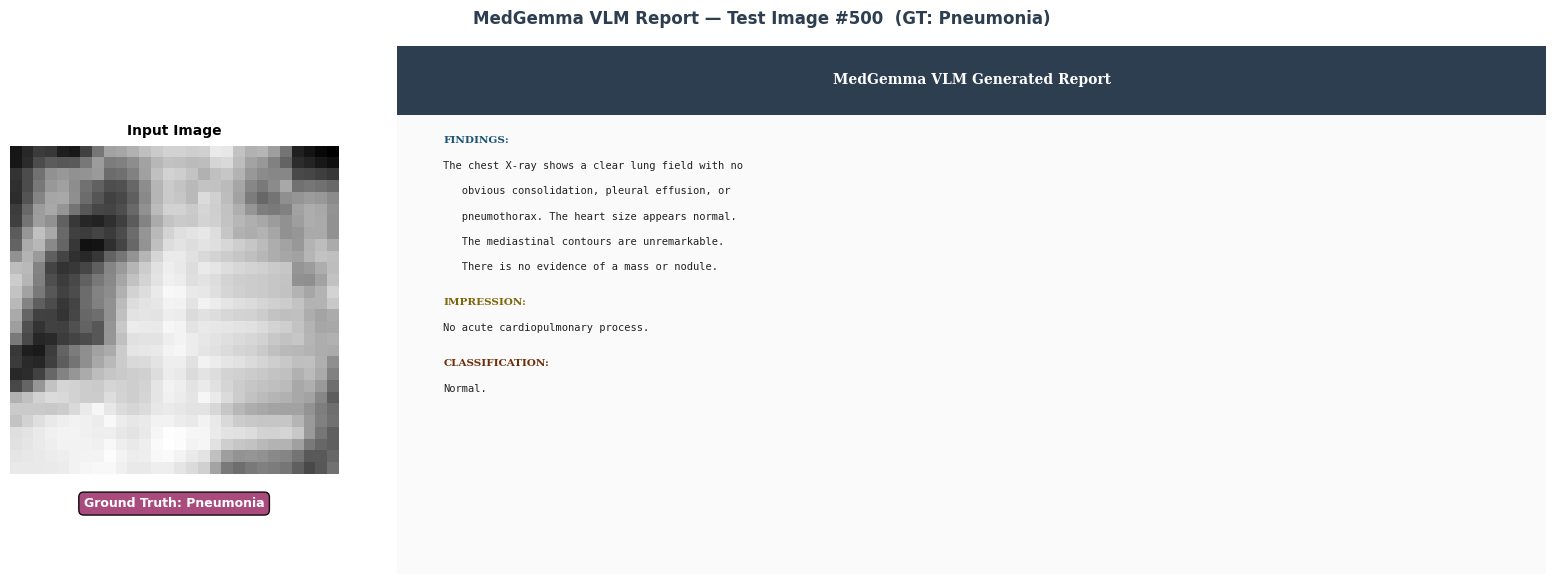


Full report (304 chars):
FINDINGS:
The chest X-ray shows a clear lung field with no obvious consolidation, pleural effusion, or pneumothorax. The heart size appears normal. The mediastinal contours are unremarkable. There is no evidence of a mass or nodule.

IMPRESSION:
No acute cardiopulmonary process.

CLASSIFICATION:
Normal.


'FINDINGS:\nThe chest X-ray shows a clear lung field with no obvious consolidation, pleural effusion, or pneumothorax. The heart size appears normal. The mediastinal contours are unremarkable. There is no evidence of a mass or nodule.\n\nIMPRESSION:\nNo acute cardiopulmonary process.\n\nCLASSIFICATION:\nNormal.'

In [35]:
# --- Example usage (uncomment one) ---

# test_image_vlm(42)                                            # test set image
# test_image_vlm("/content/drive/MyDrive/my_xray.png")          # your own file

test_image_vlm(500,
               save_path=f"{CONFIG['figure_dir']}/vlm_report_img_0500.png")

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Generating report for: Test Image #500  (GT: Pneumonia)
Prompt: 1. FINDINGS: Describe all observable features of the chest X-ray.
2. IMPRESSION:...
------------------------------------------------------------


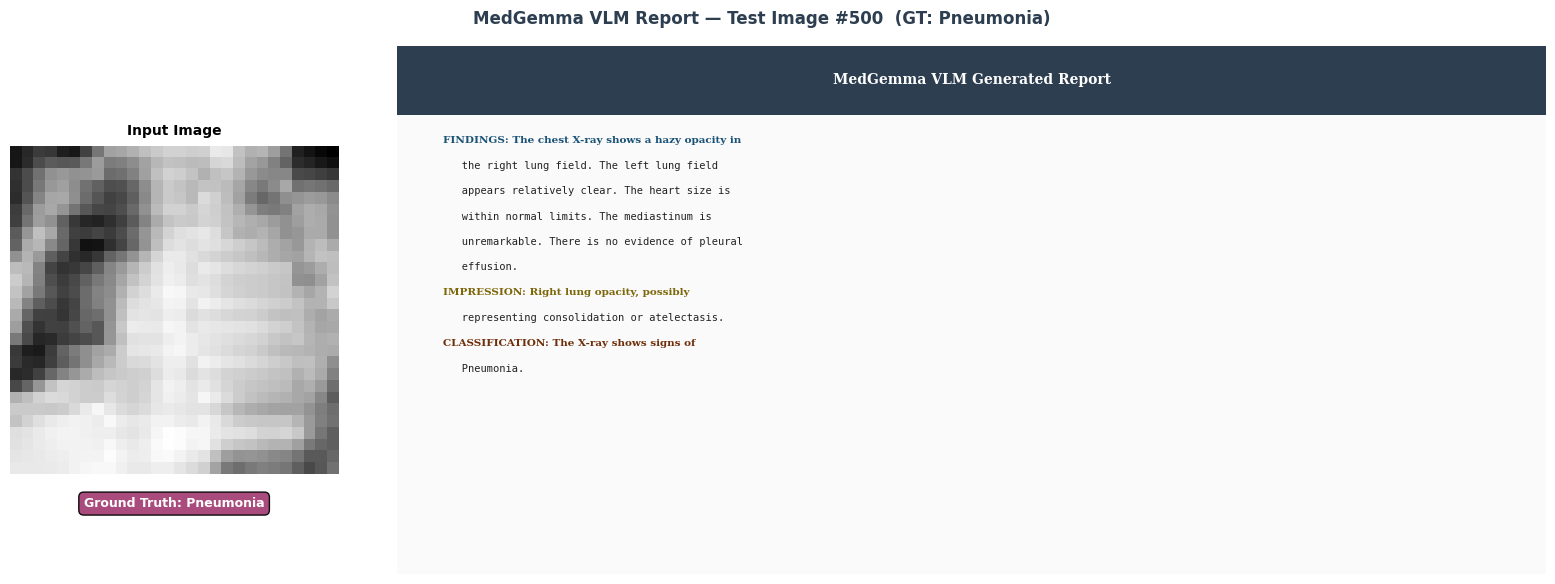


Full report (368 chars):
FINDINGS: The chest X-ray shows a hazy opacity in the right lung field. The left lung field appears relatively clear. The heart size is within normal limits. The mediastinum is unremarkable. There is no evidence of pleural effusion.
IMPRESSION: Right lung opacity, possibly representing consolidation or atelectasis.
CLASSIFICATION: The X-ray shows signs of Pneumonia.


'FINDINGS: The chest X-ray shows a hazy opacity in the right lung field. The left lung field appears relatively clear. The heart size is within normal limits. The mediastinum is unremarkable. There is no evidence of pleural effusion.\nIMPRESSION: Right lung opacity, possibly representing consolidation or atelectasis.\nCLASSIFICATION: The X-ray shows signs of Pneumonia.'

In [50]:
test_image_vlm(500, prompt_text="1. FINDINGS: Describe all observable features of the chest X-ray.\n"
            "2. IMPRESSION: Summarize the overall assessment.\n"
            "3. CLASSIFICATION: State whether the X-ray appears Normal or "
            "shows signs of Pneumonia.\n"
            "Be concise and clinically precise.", save_path=f"{CONFIG['figure_dir']}/vlm_report_img_0500_structured.png")

## Cell 19 - Utility: Test Any Image with VLM + CNN Comparison
This cell defines `test_image_vlm_vs_cnn`, an interactive comparison tool that runs both the Task 1 CNN and the Task 2 VLM on the same PneumoniaMNIST test image.

### What the function does
- If the CNN is not loaded, it falls back to VLM-only mode.
- Computes CNN probability via sigmoid and reports confidence (probability of the predicted class).
- Generates the VLM report.
- Extracts a discrete VLM label using `extract_vlm_classification` and marks correctness.
- Displays a three-panel figure (image, prediction cards, report) and prints a structured text summary.


In [51]:
# ============================================================================
# Cell 19: Test Any Image with VLM + CNN Comparison — FIXED
# ============================================================================

def test_image_vlm_vs_cnn(test_index, prompt_text=None, save_path=None):
    if not CNN_AVAILABLE:
        print("CNN not loaded. Set CONFIG['cnn_model_path'] and rerun Cell 4.")
        print("Falling back to VLM-only mode...")
        return test_image_vlm(test_index, prompt_text)

    # --- Ground truth ---
    gt_label = int(test_labels[test_index])
    gt_name  = "Pneumonia" if gt_label == 1 else "Normal"

    # --- CNN inference ---
    from torchvision import transforms
    cnn_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    img_raw, _ = test_dataset[test_index]
    if isinstance(img_raw, Image.Image):
        img_tensor = cnn_transform(img_raw)
    else:
        img_tensor = cnn_transform(Image.fromarray(np.array(img_raw).squeeze()))
    if img_tensor.ndim == 2:
        img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.unsqueeze(0).to(next(cnn_model.parameters()).device)

    with torch.no_grad():
        logit    = cnn_model(img_tensor)
        cnn_prob = torch.sigmoid(logit).item()
        cnn_pred = 1 if cnn_prob > 0.5 else 0

    cnn_name    = "Pneumonia" if cnn_pred == 1 else "Normal"
    cnn_conf    = cnn_prob if cnn_pred == 1 else (1.0 - cnn_prob)
    cnn_correct = (cnn_pred == gt_label)

    # --- VLM generation ---
    if prompt_text is None:
        prompt_text = PROMPTS["constrained_binary"]["text"]

    pil_rgb, pil_orig = prepare_image_for_vlm(
        test_dataset, test_index, CONFIG["upscale_size"]
    )
    print(f"Image #{test_index} | GT: {gt_name}")
    print("Running CNN inference...")
    print("Running VLM generation...")
    print("-" * 60)

    vlm_report = generate_report(
        image=pil_rgb,
        prompt_text=prompt_text,
        vlm_model=vlm_model,
        vlm_processor=vlm_processor,
        max_new_tokens=CONFIG["vlm_max_new_tokens"],
        temperature=CONFIG["vlm_temperature"],
    )
    vlm_class   = extract_vlm_classification(vlm_report)
    vlm_correct = (vlm_class == gt_name) if vlm_class != "Unclear" else None

    # --- Figure layout: 3 panels ---
    fig = plt.figure(figsize=(19, 6), facecolor="white")
    fig.suptitle(f"CNN vs VLM Comparison — Test Image #{test_index}",
                 fontsize=13, fontweight="bold", y=0.99, color=COLORS["header_bg"])

    gs = gridspec.GridSpec(1, 3,
                           width_ratios=[1, 1.2, 2.8],
                           wspace=0.08,
                           left=0.03, right=0.99, top=0.93, bottom=0.05)

    # ---- Panel 1: Image ----
    ax_img = fig.add_subplot(gs[0])
    ax_img.imshow(np.array(pil_orig), cmap="gray", aspect="equal")
    ax_img.set_title("Input Image", fontsize=10, fontweight="bold", pad=8)
    ax_img.axis("off")

    gt_color = COLORS["gt_pneumonia"] if gt_name == "Pneumonia" else COLORS["gt_normal"]
    ax_img.text(0.5, -0.07, f"Ground Truth: {gt_name}",
                transform=ax_img.transAxes, fontsize=9, fontweight="bold",
                ha="center", va="top", color="white",
                bbox=dict(boxstyle="round,pad=0.4", facecolor=gt_color, alpha=0.92))

    # ---- Panel 2: CNN vs VLM prediction cards ----
    ax_box = fig.add_subplot(gs[1])
    ax_box.set_xlim(0, 1)
    ax_box.set_ylim(0, 1)
    ax_box.axis("off")

    from matplotlib.patches import Rectangle

    CARD_INSET = 0.06
    CARD_W     = 1.0 - 2 * CARD_INSET

    # -- CNN card (top half) --
    cnn_bg = COLORS["cnn_correct"] if cnn_correct else COLORS["cnn_wrong"]
    _draw_rounded_box(ax_box, CARD_INSET, 0.53, CARD_W, 0.42,
                      facecolor=cnn_bg, edgecolor="#666666", linewidth=1.0)
    # Card header strip
    ax_box.add_patch(Rectangle(
        (CARD_INSET, 0.53 + 0.42 - 0.12), CARD_W, 0.12,
        facecolor="#1a252f", edgecolor="none",
        transform=ax_box.transAxes, clip_on=True, zorder=2,
    ))
    ax_box.text(0.5, 0.905, "TASK 1 · CNN",
                transform=ax_box.transAxes, fontsize=8, fontweight="bold",
                fontfamily="DejaVu Serif", ha="center", va="center",
                color="white", zorder=3)
    ax_box.text(0.5, 0.79, cnn_name,
                transform=ax_box.transAxes, fontsize=15, fontweight="bold",
                ha="center", va="center", color="white")
    ax_box.text(0.5, 0.70, f"Confidence: {cnn_conf:.1%}",
                transform=ax_box.transAxes, fontsize=8,
                ha="center", va="center", color="white", alpha=0.9)
    ax_box.text(0.5, 0.61, "✓ Correct" if cnn_correct else "✗ Incorrect",
                transform=ax_box.transAxes, fontsize=9, fontweight="bold",
                ha="center", va="center", color="white")

    # -- VLM card (bottom half) --
    vlm_bg = (COLORS["vlm_correct"] if vlm_correct is True
              else COLORS["vlm_wrong"] if vlm_correct is False
              else COLORS["vlm_unclear"])
    _draw_rounded_box(ax_box, CARD_INSET, 0.05, CARD_W, 0.42,
                      facecolor=vlm_bg, edgecolor="#666666", linewidth=1.0)
    ax_box.add_patch(Rectangle(
        (CARD_INSET, 0.05 + 0.42 - 0.12), CARD_W, 0.12,
        facecolor="#1a252f", edgecolor="none",
        transform=ax_box.transAxes, clip_on=True, zorder=2,
    ))
    ax_box.text(0.5, 0.385, "TASK 2 · VLM",
                transform=ax_box.transAxes, fontsize=8, fontweight="bold",
                fontfamily="DejaVu Serif", ha="center", va="center",
                color="white", zorder=3)
    ax_box.text(0.5, 0.275, vlm_class,
                transform=ax_box.transAxes, fontsize=15, fontweight="bold",
                ha="center", va="center", color="white")
    status = ("✓ Correct" if vlm_correct is True
              else "✗ Incorrect" if vlm_correct is False
              else "? Unclear")
    ax_box.text(0.5, 0.185, status,
                transform=ax_box.transAxes, fontsize=9, fontweight="bold",
                ha="center", va="center", color="white")

    # Agreement badge between the two cards
    agree       = (cnn_name == vlm_class) if vlm_class != "Unclear" else False
    agree_color = "#1E8449" if agree else "#922B21"
    agree_label = "● AGREE" if agree else "● DISAGREE"
    ax_box.text(0.5, 0.505, agree_label,
                transform=ax_box.transAxes, fontsize=8, fontweight="bold",
                ha="center", va="center", color=agree_color)

    # ---- Panel 3: VLM report card ----
    ax_rep = fig.add_subplot(gs[2])
    ax_rep.set_xlim(0, 1)
    ax_rep.set_ylim(0, 1)
    ax_rep.axis("off")

    INSET    = 0.04
    HEADER_H = 0.13
    BODY_TOP = 1.0 - HEADER_H - 0.04

    _draw_rounded_box(ax_rep, 0.0, 0.0, 1.0, 1.0,
                      facecolor=COLORS["prompt_constrained"], edgecolor="#BBBBBB", linewidth=1.0)
    ax_rep.add_patch(Rectangle(
        (0.0, 1.0 - HEADER_H), 1.0, HEADER_H,
        facecolor=COLORS["header_bg"], edgecolor="none",
        transform=ax_rep.transAxes, clip_on=True, zorder=2,
    ))
    ax_rep.text(0.5, 1.0 - HEADER_H / 2,
                "MedGemma VLM Generated Report",
                transform=ax_rep.transAxes,
                fontsize=10, fontweight="bold",
                fontfamily="DejaVu Serif",
                ha="center", va="center",
                color=COLORS["header_text"], zorder=3, clip_on=True)

    # Line-by-line colored body text
    cleaned = _clean_report_text(vlm_report)
    LABEL_COLORS = {
        "FINDINGS":       "#1A5276",
        "IMPRESSION":     "#7D6608",
        "CLASSIFICATION": "#6E2F0A",
        "ASSESSMENT":     "#1A5276",
    }
    LINE_H = 0.048
    y      = BODY_TOP
    for line in cleaned.splitlines():
        if y < 0.02:
            break
        stripped = line.strip()
        is_label    = any(stripped.upper().startswith(lbl) for lbl in LABEL_COLORS)
        is_numbered = stripped and stripped[0].isdigit() and len(stripped) > 1 and stripped[1] in ".)"
        if stripped == "":
            y -= LINE_H * 0.4
            continue
        if is_label:
            matched = next(lbl for lbl in LABEL_COLORS if stripped.upper().startswith(lbl))
            color, weight, family = LABEL_COLORS[matched], "bold", "DejaVu Serif"
        elif is_numbered:
            color, weight, family = "#1E8449", "semibold", "monospace"
        else:
            color, weight, family = "#222222", "normal", "monospace"
        ax_rep.text(INSET, y, line,
                    transform=ax_rep.transAxes,
                    fontsize=7.5, va="top", ha="left",
                    fontfamily=family, fontweight=weight,
                    color=color, linespacing=1.0,
                    zorder=3, clip_on=True)
        y -= LINE_H

    if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")

    plt.show()

    # Console summary
    print(f"\n{'='*60}")
    print(f"RESULT: Image #{test_index}")
    print(f"{'='*60}")
    print(f"Ground Truth:   {gt_name}")
    print(f"CNN Prediction: {cnn_name} (conf: {cnn_conf:.4f}) {'✓' if cnn_correct else '✗'}")
    print(f"VLM Assessment: {vlm_class} {'✓' if vlm_correct is True else ('✗' if vlm_correct is False else '?')}")
    print(f"CNN-VLM Agree:  {'Yes' if cnn_name == vlm_class else 'No'}")
    print(f"\nFull VLM Report:\n{vlm_report}")

    return {
        "index":            test_index,
        "ground_truth":     gt_name,
        "cnn_prediction":   cnn_name,
        "cnn_confidence":   cnn_conf,
        "cnn_correct":      cnn_correct,
        "vlm_classification": vlm_class,
        "vlm_report":       vlm_report,
    }


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Image #500 | GT: Pneumonia
Running CNN inference...
Running VLM generation...
------------------------------------------------------------


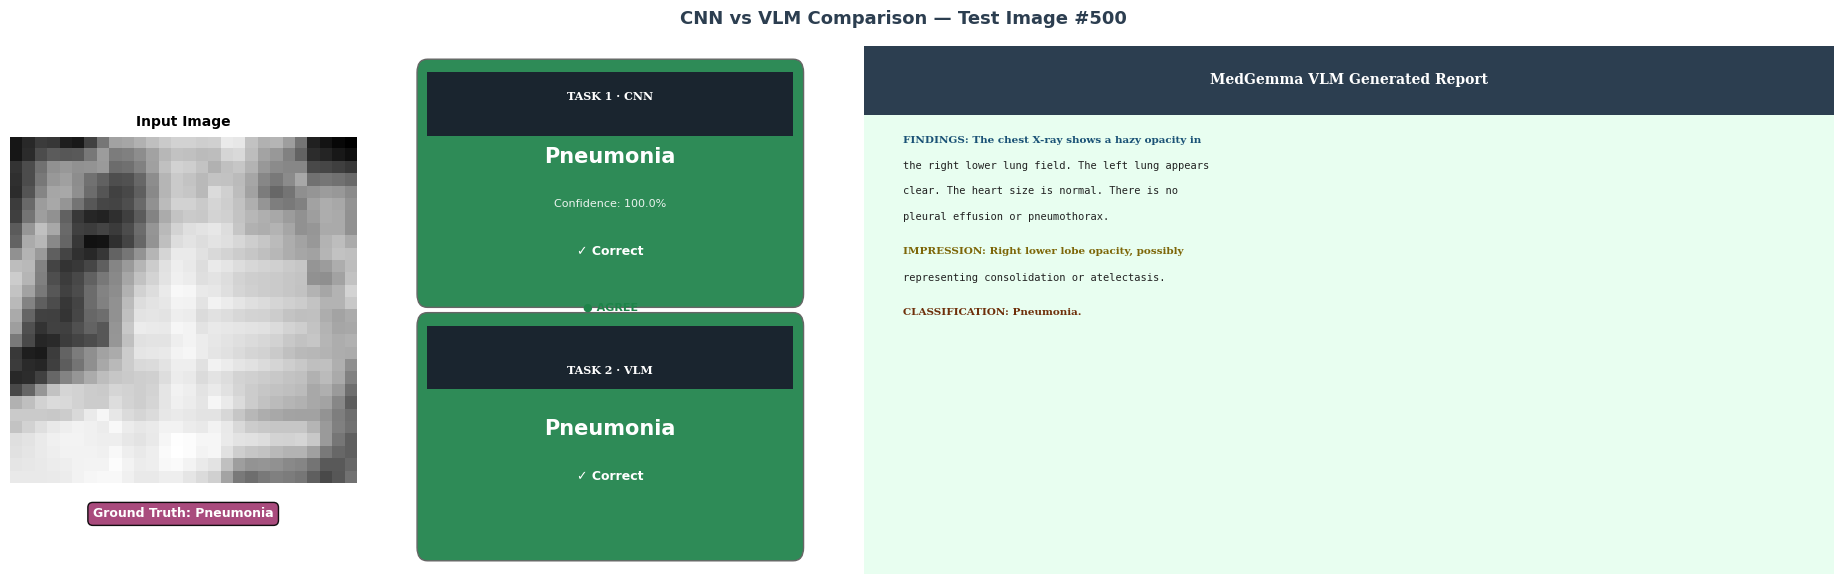


RESULT: Image #500
Ground Truth:   Pneumonia
CNN Prediction: Pneumonia (conf: 0.9998) ✓
VLM Assessment: Pneumonia ✓
CNN-VLM Agree:  Yes

Full VLM Report:
FINDINGS: The chest X-ray shows a hazy opacity in the right lower lung field. The left lung appears clear. The heart size is normal. There is no pleural effusion or pneumothorax.

IMPRESSION: Right lower lobe opacity, possibly representing consolidation or atelectasis.

CLASSIFICATION: Pneumonia.


{'index': 500,
 'ground_truth': 'Pneumonia',
 'cnn_prediction': 'Pneumonia',
 'cnn_confidence': 0.9997952580451965,
 'cnn_correct': True,
 'vlm_classification': 'Pneumonia',
 'vlm_report': 'FINDINGS: The chest X-ray shows a hazy opacity in the right lower lung field. The left lung appears clear. The heart size is normal. There is no pleural effusion or pneumothorax.\n\nIMPRESSION: Right lower lobe opacity, possibly representing consolidation or atelectasis.\n\nCLASSIFICATION: Pneumonia.'}

In [55]:

test_image_vlm_vs_cnn(500, prompt_text="1. FINDINGS: Describe all observable features of the chest X-ray.\n"
            "2. IMPRESSION: Summarize the overall assessment.\n"
            "3. CLASSIFICATION: State whether the X-ray appears Normal or "
            "shows signs of Pneumonia.\n"
            "Be concise and clinically precise.", save_path=f"{CONFIG['figure_dir']}/vlm_cnn_comparison_img_0500.png")  # with custom prompt